In [1]:

from metrics import plot_confusion
from IPython.display import Image
from keras.utils import plot_model
import numpy as np
import tensorflow.keras.backend as k
from tensorflow.keras.layers import Dense, Input, Layer, InputSpec
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics
from data import load_data


In [2]:
size = 10000
max_iter = 140
# entities = ['ORG', 'GPE', 'PERSON', ]  # , 'NORP',  ]
x, y, mapping, strings = load_data(size, get_text=True)
n_clusters = len(np.unique(y))+10
print(x.shape)


Loading ./data/conll_spacy_10000.pkl
Done: (37748, 772)
Train data balance:
Most frequent words: 
         entity  freq
0           GPE  1842
1        PERSON  1454
2           ORG  1344
3          DATE  1100
4          NORP   102
5          TIME   101
6       PERCENT    96
7           LOC    80
8      QUANTITY    75
9         MONEY    73
10          FAC    69
11     CARDINAL    44
12        EVENT    32
13      PRODUCT    21
14  WORK_OF_ART     8
15      ORDINAL     6
16     LANGUAGE     5


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (33156, 768), y: (33156,)
(33156, 768)


In [3]:

def autoencoder_model(layer_specs: list, act: str='relu', init_fn: str='glorot_uniform'):
    """
    Creates the autoencoder given
    -layer_specs: list of layer sizes.
        Model is symmetrical so only need to specify the first half.
    -act: activation function for hidden layers
    -init_fn: initializer for weights

    returns:
        - the full autoencoder
        - the encoder only
    """
    layers = len(layer_specs) - 1
    # input
    input_img = Input(shape=(layer_specs[0],), name='input')
    x = input_img

    # hidden layers in encoder
    for i in range(layers-1):
        x = Dense(
            layer_specs[i + 1],
            activation=act,
            kernel_initializer=init_fn,
            name=f'encoder_{i}')(x)

    # latent layer
    encoder = Dense(
        layer_specs[-1],
        kernel_initializer=init_fn,
        name=f'encoder_{layers - 1}')(x)

    x = encoder
    # hidden layers in decoder
    for i in range(layers-1, 0, -1):
        x = Dense(
            layer_specs[i],
            activation=act,
            kernel_initializer=init_fn,
            name=f'decoder_{i}')(x)

    # output
    x = Dense(layer_specs[0], kernel_initializer=init_fn, name='decoder_0')(x)
    decoder = x
    return (Model(inputs=input_img, outputs=decoder, name='AE'),
            Model(inputs=input_img, outputs=encoder, name='encoder'))


In [4]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred_kmeans = kmeans.fit_predict(x)


In [5]:
metrics.acc(y, y_pred_kmeans)


0.26492942453854507

In [6]:
dims = [x.shape[-1], 500, 500, 2000, 50]
init = VarianceScaling(
                    mode='fan_in',
                    scale=1. / 3.,
                    distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './results'


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [7]:


class ClusteringLayer(Layer):
    """
    Clustering layer predicts the cluster assignments for each sample in the batch.
    Calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(num_clusters=10))
    ```
    # Arguments
        num_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` which
            represents the initial cluster centers from pretraining.
        alpha: degrees of freedom parameter in Student's t-distribution.
            Default to 1.0.
    """

    def __init__(self, num_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.num_clusters = num_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=k.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(
            shape=(self.num_clusters, input_dim),
            initializer='glorot_uniform',
            name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. 
                shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (k.sum(k.square(k.expand_dims(inputs,
                   axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        # Make sure each sample's 10 values add up to 1.
        q = k.transpose(k.transpose(q) / k.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.num_clusters

    def get_config(self):
        config = {'n_clusters': self.num_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))




In [8]:
autoencoder, encoder = autoencoder_model(dims, init=init)



In [9]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size,
                epochs=pretrain_epochs)  # , callbacks=cb)
autoencoder.save_weights(save_dir + '/jae_weights.h5')


Epoch 1/300
130/130 [==============================] - 1s 4ms/step - loss: 0.0988
Epoch 2/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0898
Epoch 3/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0856
Epoch 4/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0791
Epoch 5/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0716
Epoch 6/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0634
Epoch 7/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0551
Epoch 8/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0486
Epoch 9/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0437
Epoch 10/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0401
Epoch 11/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0370
Epoch 12/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0344
Epoch 13/300


In [ ]:
autoencoder.load_weights(save_dir+'/jae_weights.h5')
clustering_layer = ClusteringLayer(
    n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
              outputs=[clustering_layer, autoencoder.output])


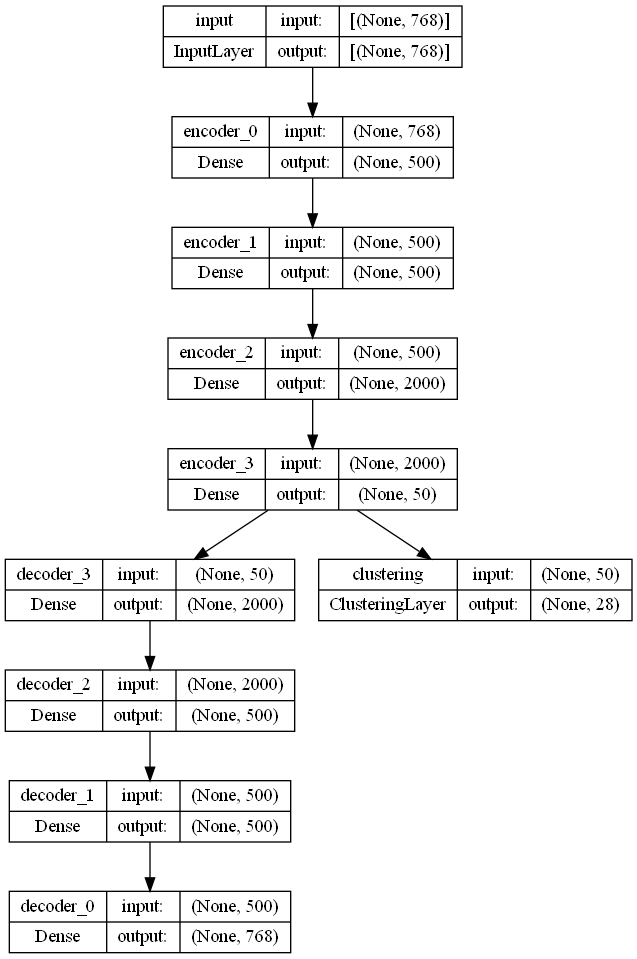

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')


In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)


1037/1037 [==============================] - 1s 561us/step


In [ ]:
model.compile(loss=['kld', 'mse'], loss_weights=[
              0.1, 1], optimizer=pretrain_optimizer)


In [ ]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001  # tolerance threshold to stop training


In [ ]:


def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T



In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _ = model.predict(x, verbose=0)
        # update the auxiliary target distribution p
        p = target_distribution(q)

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print(f'Acc = {acc:.5f}, nmi = {nmi:.5f}, ari = {ari:.5f}'
                  f' ; loss={loss}')

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(
            np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index *
                      batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')


Iter 0: acc = 0.30842, nmi = 0.40107, ari = 0.18782  ; loss= 0
Iter 140: acc = 0.31460, nmi = 0.40798, ari = 0.19122  ; loss= [0.06721 0.06273 0.06093]
Iter 280: acc = 0.30498, nmi = 0.40032, ari = 0.17931  ; loss= [0.06638 0.0793  0.05845]
Iter 420: acc = 0.30911, nmi = 0.40154, ari = 0.18292  ; loss= [0.07143 0.11534 0.05989]
Iter 560: acc = 0.29325, nmi = 0.39591, ari = 0.17219  ; loss= [0.08124 0.18476 0.06276]
Iter 700: acc = 0.30212, nmi = 0.39865, ari = 0.17779  ; loss= [0.08193 0.2468  0.05725]
Iter 840: acc = 0.28722, nmi = 0.38014, ari = 0.16344  ; loss= [0.05093 0.17918 0.03301]
Iter 980: acc = 0.28417, nmi = 0.36632, ari = 0.15128  ; loss= [0.03208 0.15025 0.01706]
Iter 1120: acc = 0.29711, nmi = 0.37990, ari = 0.16077  ; loss= [0.12108 0.23409 0.09767]
Iter 1260: acc = 0.28797, nmi = 0.36521, ari = 0.15319  ; loss= [0.08369 0.20274 0.06342]
Iter 1400: acc = 0.27808, nmi = 0.36209, ari = 0.14794  ; loss= [0.05581 0.10185 0.04562]
Iter 1540: acc = 0.28882, nmi = 0.37097, ari

In [ ]:

model.load_weights(save_dir + '/b_DEC_model_final.h5')


In [ ]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print(f'Acc = {acc:.5f}, nmi = {nmi:.5f}, ari = {ari:.5f}'
          f' ; loss={loss}')


Acc = 0.30281, nmi = 0.36665, ari = 0.16285  ; loss= 0


In [ ]:
len(np.unique(y_pred))


27

In [ ]:
print(mapping)


{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'WORK_OF_ART', 8: 'LANGUAGE', 9: 'LAW', 10: 'DATE', 11: 'TIME', 12: 'PERCENT', 13: 'MONEY', 14: 'QUANTITY', 15: 'ORDINAL', 16: 'CARDINAL', 17: 'FAC'}


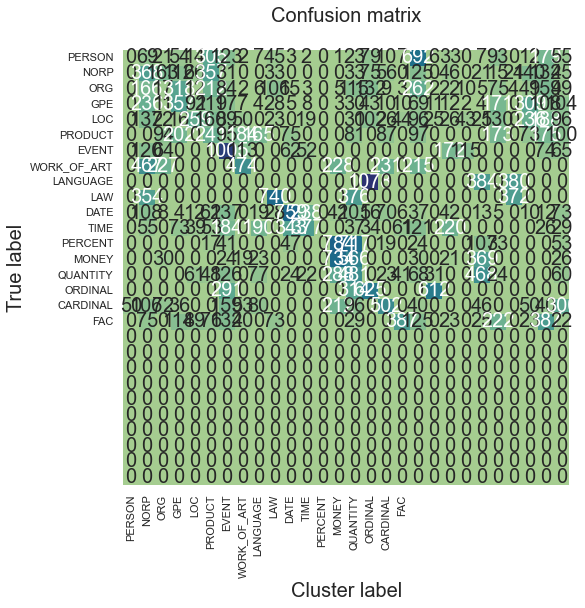

In [ ]:
plot_confusion(y, y_pred, mapping, 8)


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(i: int, cluster: dict)-> None:
    """
    Show wordcloud for a cluster.
    """
    freqs = cluster['freqs']
    frac = cluster['frac']
    n = cluster['n']
    name = cluster['name']
    print(f'{i}: "{name}", {n} items, ({frac*100:.2f}% confidence)')
    if len(freqs) > 0:
        wc = WordCloud().generate_from_frequencies(freqs)
        plt.figure(figsize=(16, 14))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    else:
        print(f"No words for cluster {cluster}")


CLUSTERS
13: "UNK-15 Was TIME", 571 items, (33.27% confidence)


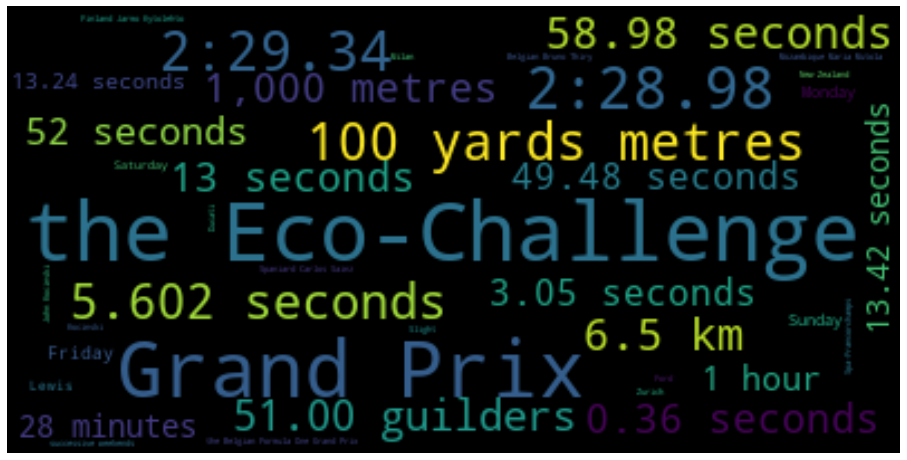

15: "UNK-26 Was CARDINAL", 1077 items, (27.86% confidence)


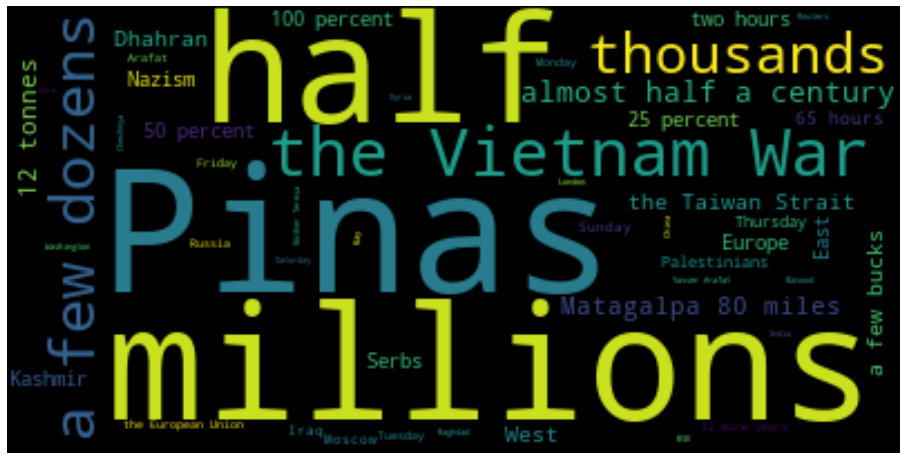

16: "UNK-22 Was FAC", 941 items, (23.59% confidence)


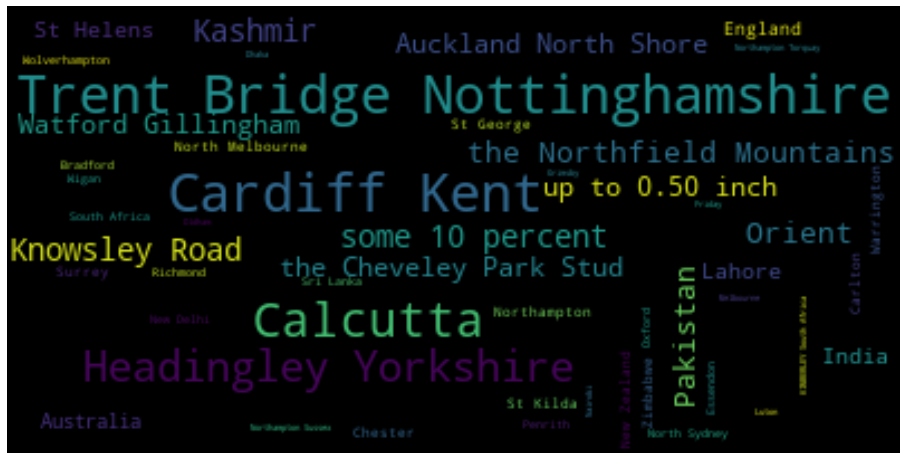

18: "UNK-21 Was WORK_OF_ART", 2261 items, (20.65% confidence)


19: "UNK-7", 0 items, (0.00% confidence)
No words for cluster {'freqs': {}, 'frac': 0, 'n': 0, 'name': 'UNK-7', 'idx': 6}
0: "CARDINAL", 50 items, (100.00% confidence)


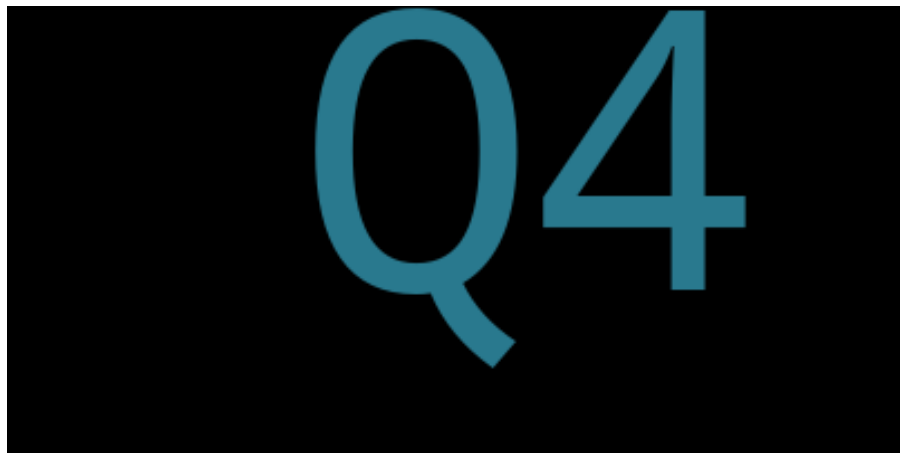

1: "ORDINAL", 687 items, (89.08% confidence)


2: "FAC", 559 items, (69.23% confidence)


3: "LAW", 1076 items, (68.77% confidence)


4: "EVENT", 170 items, (67.65% confidence)


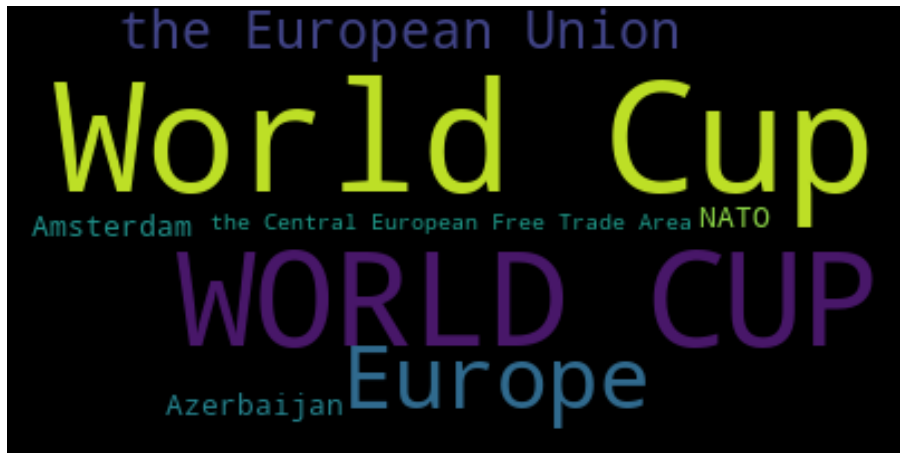

5: "DATE", 1333 items, (56.94% confidence)


6: "TIME", 721 items, (52.29% confidence)


7: "WORK_OF_ART", 944 items, (50.21% confidence)


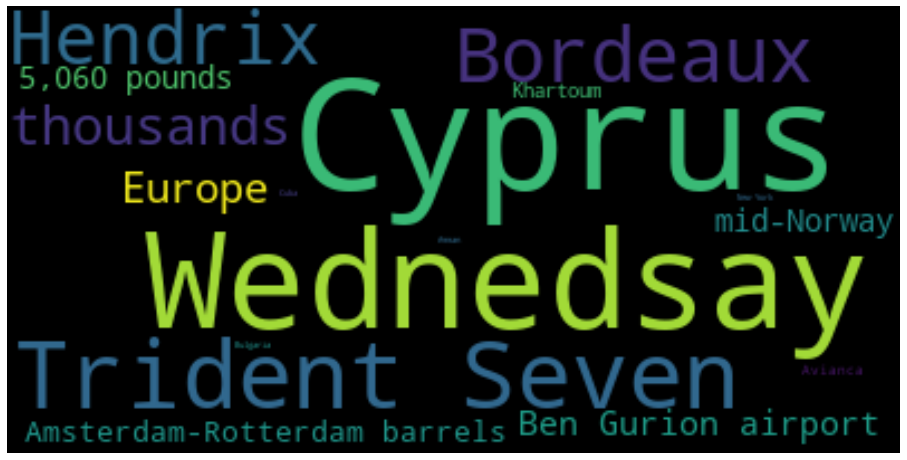

8: "LANGUAGE", 780 items, (48.72% confidence)


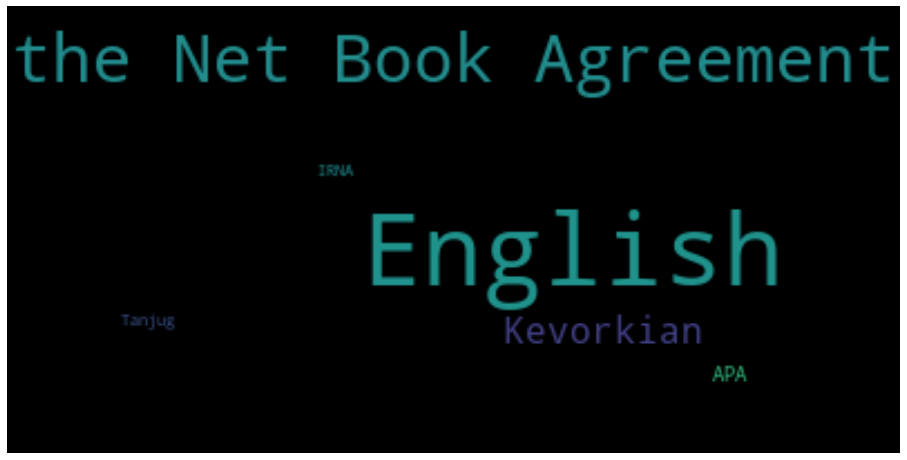

9: "LOC", 644 items, (40.22% confidence)


10: "PERSON", 2001 items, (34.58% confidence)


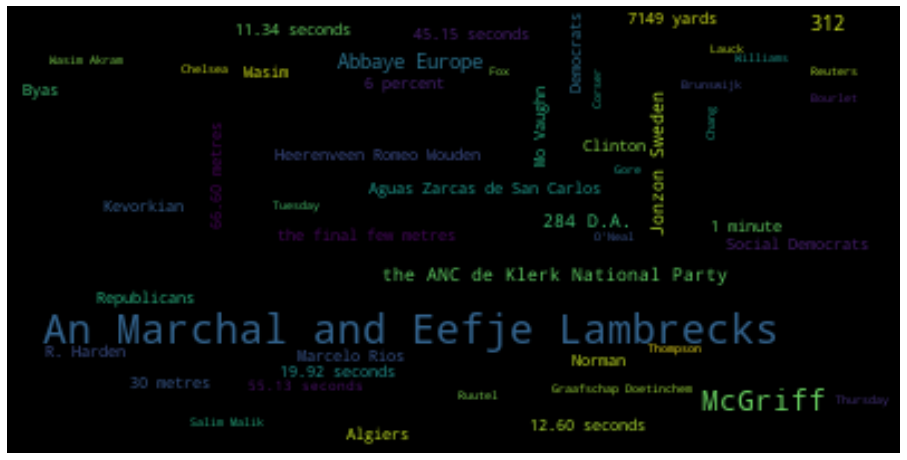

11: "GPE", 902 items, (34.26% confidence)


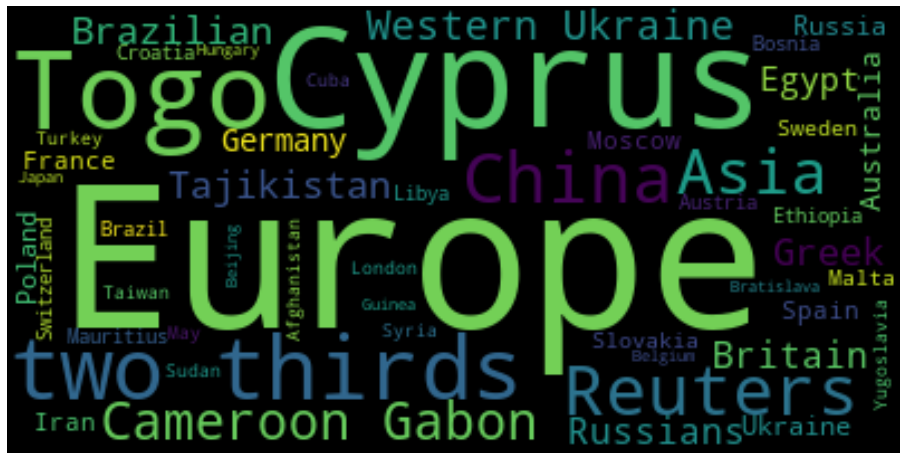

12: "PERCENT", 2297 items, (34.13% confidence)


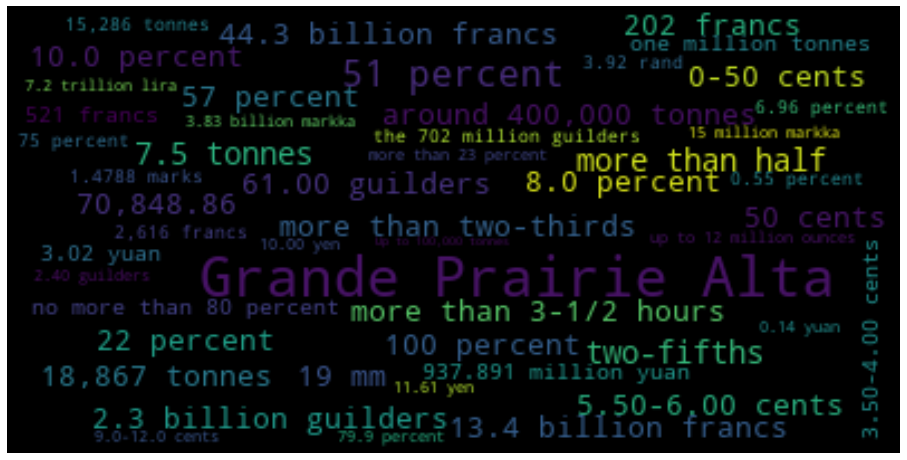

14: "QUANTITY", 1474 items, (31.75% confidence)


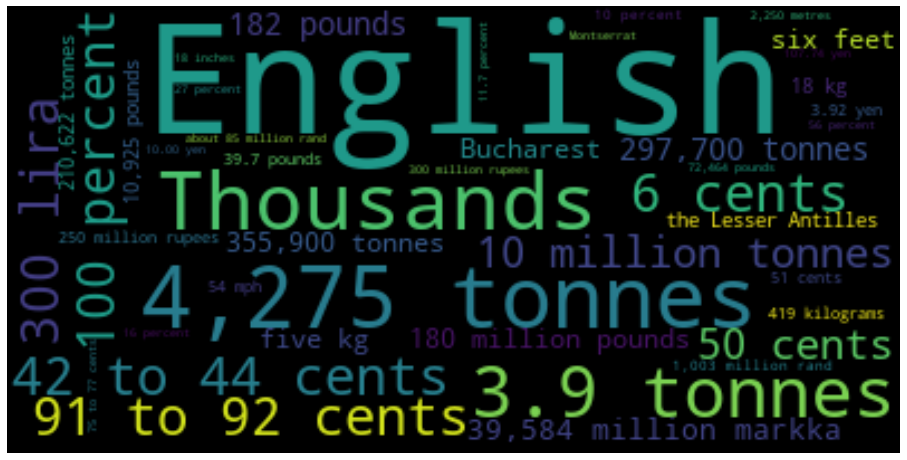

17: "NORP", 1642 items, (21.74% confidence)


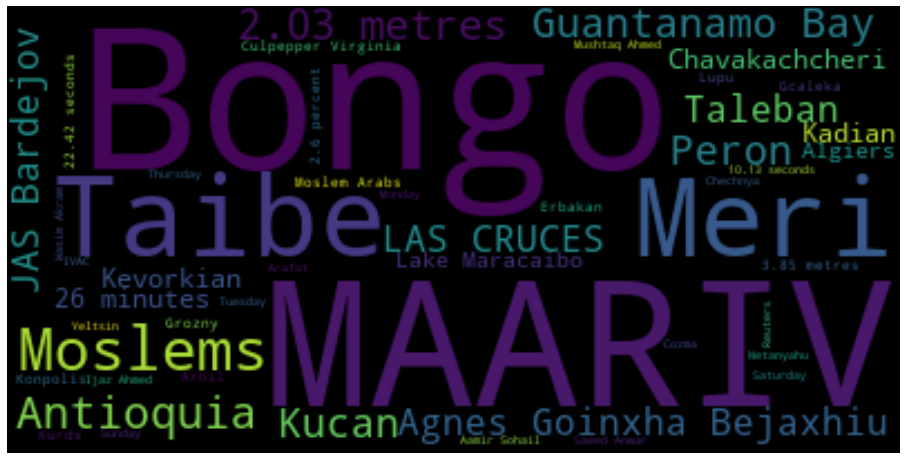

In [ ]:
import numpy as np
import pandas as pd

print ("CLUSTERS")
clusters = {}
predicted = pd.DataFrame({'text':strings, 'y_pred':y_pred, 'y_true':y})
for cluster_no in range(n_clusters):
    y_pred_for_key = predicted[predicted['y_pred']==cluster_no]
    true_label = 'UNKNOWN'
    modal_value = y_pred_for_key['y_true'].mode()
    if len(modal_value)>0:
        if modal_value[0] in mapping:
            true_label = mapping[modal_value[0]]
        # confidence - fraction of this cluster that is actually this cluster
        y_true_this_cluster = len(y_pred_for_key[y_pred_for_key['y_true']==modal_value[0]])
        frac = y_true_this_cluster/len(y_pred_for_key)
    else:
        frac = 0

    # wordcloud
    unique, counts = np.unique(y_pred_for_key['text'], return_counts=True)
    freq_list = np.asarray((unique, counts)).T
    freq_list =  sorted(freq_list, key=lambda x: -x[1])[0:50]
    freqs = {w: f for w,f in freq_list}
    entry = {'freqs':freqs, 'frac':frac, 'n':len(y_pred_for_key)}
    if true_label == 'UNKNOWN':
        clusters[f"UNK-{cluster_no}"] = entry
    elif true_label in clusters:
        if clusters[true_label]['frac'] < frac:
            # we found a better cluster for this label
            clusters[true_label] = entry
        else:
            # this cluster is worse than the one we already have, so it's unknown
            clusters[f"UNK-{cluster_no} Was {true_label}"] = entry
    else:
        clusters[true_label] = entry

cluster_list = [{
    **clusters[c],
    'name': c,
    'idx': idx} for idx, c in enumerate(clusters)]
cluster_list = sorted(cluster_list, key=lambda x: -x['frac'])

# show unknown clusters first
for i, cluster in enumerate(cluster_list):
    if cluster['name'][0:3] == "UNK":
        show_wordcloud(i, cluster)

# next show known clusters
for i, cluster in enumerate(cluster_list):
    if cluster['name'][0:3] != "UNK":
        show_wordcloud(i, cluster)

# Tuning

In [1]:

import os
import numpy as np
import tensorflow.keras.backend as k
import matplotlib.pyplot as plt
import metrics
from pandas import DataFrame
from metrics import plot_confusion
from IPython.display import Image
from tensorflow.keras import models
from keras.utils import plot_model
from tqdm import tqdm
from tensorflow.keras.layers import Dense, Input, Layer, InputSpec
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from data import load_data
from wordcloud import WordCloud

In [2]:
def autoencoder_model(layer_specs: list, act: str='tanh', init_fn: str='glorot_uniform'):
    """
    Creates the autoencoder given
    -layer_specs: list of layer sizes.
        Model is symmetrical so only need to specify the first half.
    -act: activation function for hidden layers
    -init_fn: initializer for weights

    returns:
        - the full autoencoder
        - the encoder only
    """
    layers = len(layer_specs) - 1
    # input
    input_img = Input(shape=(layer_specs[0],), name='input')
    x = input_img

    # hidden layers in encoder
    for i in range(layers-1):
        x = Dense(
            layer_specs[i + 1],
            activation=act,
            kernel_initializer=init_fn,
            name=f'encoder_{i}')(x)

    # latent layer
    encoder = Dense(
        layer_specs[-1],
        kernel_initializer=init_fn,
        name=f'encoder_{layers - 1}')(x)

    x = encoder
    # hidden layers in decoder
    for i in range(layers-1, 0, -1):
        x = Dense(
            layer_specs[i],
            activation=act,
            kernel_initializer=init_fn,
            name=f'decoder_{i}')(x)

    # output
    x = Dense(layer_specs[0], kernel_initializer=init_fn, name='decoder_0')(x)
    decoder = x
    return (Model(inputs=input_img, outputs=decoder, name='AE'),
            Model(inputs=input_img, outputs=encoder, name='encoder'))

In [3]:
class ClusteringLayer(Layer):
    """
    Clustering layer predicts the cluster assignments for each sample in the batch.
    Calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(num_clusters=10))
    ```
    # Arguments
        num_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` which
            represents the initial cluster centers from pretraining.
        alpha: degrees of freedom parameter in Student's t-distribution.
            Default to 1.0.
    """

    def __init__(self, num_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.num_clusters = num_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=k.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(
            shape=(self.num_clusters, input_dim),
            initializer='glorot_uniform',
            name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. 
                shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (k.sum(k.square(k.expand_dims(inputs,
                   axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        # Make sure each sample's 10 values add up to 1.
        q = k.transpose(k.transpose(q) / k.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.num_clusters

    def get_config(self):
        config = {'n_clusters': self.num_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [4]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T


In [5]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn import mixture
from scipy.stats import multivariate_normal


def do_clustering(clustering: str, n_clusters: int, z_state: DataFrame, params={}):
    """
    Perform clustering on the data.
        -clustering: the clustering algorithm to use
        -n_clusters: the number of clusters to use
        -z_state: the data to cluster
        -params: dict, optional
            'eps' or 'min_samples' values for DBSCAN/OPTICS
    Returns:
        - the cluster assignments
        - cluster centers
    """
    dbscan_eps = 1
    dbscan_min_samples = 5
    
    if 'eps' in params:
        dbscan_eps = params['eps']
    if 'min_samples' in params:
        dbscan_min_samples = params['min_samples']

    if clustering == 'GMM':
        gmix = mixture.GaussianMixture(
            n_components=n_clusters, covariance_type='full')
        gmix.fit(z_state)
        y_pred = gmix.predict(z_state)
        # get centres
        centers = np.empty(shape=(gmix.n_components, z_state.shape[1]))
        for i in range(gmix.n_components):
            density = multivariate_normal(
                cov=gmix.covariances_[i],
                mean=gmix.means_[i]).logpdf(z_state)
            centers[i, :] = z_state[np.argmax(density)]
    elif clustering == 'Kmeans':
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)
        y_pred = kmeans.fit_predict(z_state)
        centers = kmeans.cluster_centers_
    elif clustering == 'DBSCAN':
        dbscan = DBSCAN(
            eps=dbscan_eps,
            min_samples=dbscan_min_samples,
            metric='manhattan')
        y_pred = dbscan.fit_predict(z_state)
        centers = dbscan.components_
    elif clustering == 'OPTICS':
        optics = OPTICS(min_samples=dbscan_min_samples)
        y_pred = optics.fit_predict(z_state)
        centers = optics.components_
    elif clustering=="agg":
        agg = AgglomerativeClustering(n_clusters=n_clusters, affinity='manhattan', linkage='average')
        y_pred = agg.fit_predict(z_state)
        centers = None
    else:
        raise ValueError('Clustering algorithm not specified/unknown.')

    return y_pred, centers

In [6]:
from linear_assignment import linear_assignment

def cluster_acc(y_true, y_pred, y_pred_cluster):
    y_true = y_true.astype(np.int64)
    assert y_pred_cluster.size == y_true.size
    D = max(y_pred_cluster.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred_cluster.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    c_loss = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred_cluster.size
    print(f"Cluster Loss {c_loss} on {y_pred_cluster.size} clusters")
    return c_loss

In [7]:
from linear_assignment import linear_assignment

def cluster_loss(clustering:str, n_clusters: int):
    def loss(y_true, y_pred):
        y_pred_cluster, _ = do_clustering(clustering, n_clusters, y)
        return cluster_acc(y_true, y_pred, y_pred_cluster)
    return loss

In [8]:
# write_messages.py

from jinja2 import Environment, FileSystemLoader
from pathlib import Path

def write_results_page(clusters, save_dir, test_name):
    
    environment = Environment(loader=FileSystemLoader("templates/"))
    template = environment.get_template("index.jinja")

    results_filename = os.path.join(save_dir, "index.html")
    results_template = environment.get_template("index.jinja")
    context = {
        "clusters": clusters,
        "test_name": test_name,
    }
    with open(results_filename, mode="w", encoding="utf-8") as results:
        results.write(results_template.render(context))
        full_filename = Path(results_filename).absolute()
        print (f'... wrote results  <a href="{full_filename}">{full_filename}</a>')

In [9]:
def show_wordcloud(i: int, cluster: dict, filepath: str, width: int=16, save_only: bool=False)-> None:
    """
    Show wordcloud for a cluster.
    """
    freqs = cluster['freqs']
    frac = cluster['frac']
    n = cluster['n']
    name = cluster['name']
    print(f'{i}: "{name}", {n} items, ({frac*100:.2f}% confidence)')
    if len(freqs) > 0:
        wc = WordCloud(width=800, height=500).generate_from_frequencies(freqs)
        if not save_only:
            plt.figure(figsize=(width, width-1))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.show()
        wc.to_file(filepath)
    else:
        print(f"No words for cluster {cluster}")

In [19]:
ENTITY_FILTER_LIST = ['GPE', 'PERSON', 'ORG', 'DATE', 'NORP',
    'TIME', 'PERCENT', 'LOC', 'QUANTITY', 'MONEY', 'FAC', 'CARDINAL',
    'EVENT', 'PRODUCT', 'WORK_OF_ART', 'ORDINAL', 'LANGUAGE']

class DeepCluster():

    def __init__(
                self,
                run_name: str,
                train_size: int,
                num_clusters: int,
                cluster: str="GMM",
                entities: list[str]=None,
                entity_count: int=0,
                dims: list[int] = None,
                ):

        self.cluster = cluster
        self.num_clusters = num_clusters

        if entities is not None and entity_count > 0:
            raise ValueError('entities and entity_count cannot both be specified')
        if entities is None:
            if entity_count==0:
                self.entities = ENTITY_FILTER_LIST
            else:
                self.entities = ENTITY_FILTER_LIST[:entity_count]
        else:
            self.entities = entities
        
        self.x = None
        self.y = None
        self.mapping = None
        self.strings = None
        self.y_pred_last = None
        self.input_dim = 768
        
        self.dims = [768, 500, 500, 2000, 100] if dims is None else dims
        self.run_name = run_name
        self.train_size = train_size
        self.model = None
        self.encoder = None
        self.autoencoder = None
        self.save_dir = None


    def make_data(self, oversample: bool=True) -> None:
        
        print("Load Data")
        self.x, self.y, self.mapping, self.strings = load_data(
                                    self.train_size,
                                    entity_filter=self.entities,
                                    get_text=True,
                                    oversample=oversample)
        self.input_dim = self.x.shape[1]
        print("Data Loaded")   

    
    def init_cluster_centers(self) -> None:
        """
        Initialize cluster centers by randomly sampling from the data.
        """
        print("cluster init")
        if self.x.shape[0] > 10000:
            x_sample = self.x[np.random.choice(self.x.shape[0], 100, replace=False)]
        else:
            x_sample = self.x
        y_pred, centers = do_clustering(
            'GMM' if self.cluster=='GMM' else 'Kmeans',
            self.num_clusters,
            self.encoder.predict(x_sample))
        del x_sample
        self.model.get_layer(name='clustering').set_weights([centers])
        self.y_pred_last = np.copy(y_pred)
        print("cluster init done")

    def make_model(self) -> None:
        
        init = VarianceScaling(
                            mode='fan_in',
                            scale=1. / 3.,
                            distribution='uniform')
        pretrain_optimizer = 'adam'# SGD(learning_rate=1, momentum=0.9)
        
        self.autoencoder, self.encoder = autoencoder_model(self.dims, init_fn=init)
        self.autoencoder.compile(
            optimizer=pretrain_optimizer,
            loss=['mse'])

        

        clustering_layer = ClusteringLayer(
            self.num_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input,
                    outputs=[clustering_layer, self.autoencoder.output])
        self.model.compile(
            loss=['kld', 'mse', cluster_loss(self.cluster, self.num_clusters)],
            loss_weights=[0.3, 1, 0.2],
            optimizer=SGD(learning_rate=1, momentum=0.9))
        
        self.save_dir = f'./results/{self.run_name}'
        if not os.path.exists(self.save_dir):
            # create save dir
            os.makedirs(self.save_dir)
        img_file = os.path.join(self.save_dir, 'model.png')
        plot_model(self.model, to_file=img_file, show_shapes=True)
        Image(filename=img_file)

    def target_distribution(self, q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T


    
    def train_model(self):
        """
        Run the model.
        """
        self.make_data(oversample=True)

        print("Data Loaded")   

        max_iter = 140
        pretrain_epochs = 300
        batch_size = 256
        
        self.make_model()
        

        print("Training autoencoder")
        early_stopping_cb = EarlyStopping(
            monitor='loss', patience=5, verbose=1, min_delta=0.0003)
        history = self.autoencoder.fit(
                                self.x,
                                self.x,
                                batch_size=batch_size,
                                epochs=pretrain_epochs, 
                                verbose=0,
                                callbacks=[early_stopping_cb])
        self.autoencoder.save_weights(os.path.join(self.save_dir, 'jae_weights.h5'))
        print("Trained autoencoder")
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.title('Autoencoder pretraining loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        # init cluster centres before train
        self.init_cluster_centers()

        # train full model
        self.train(batch_size)
        print("Training Done")


    def train(self, batch_size: int):
        loss = 0
        index = 0
        maxiter = 8000
        update_interval = 140
        index_array = np.arange(self.x.shape[0])
        tol = 0.001  # tolerance threshold to stop training

        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q, _ = self.model.predict(self.x, verbose=0)
                # update the auxiliary target distribution p
                p = self.target_distribution(q)

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if self.y is not None:
                    acc = np.round(metrics.acc(self.y, y_pred), 5)
                    nmi = np.round(metrics.nmi(self.y, y_pred), 5)
                    ari = np.round(metrics.ari(self.y, y_pred), 5)
                    loss = np.round(loss, 5)
                    print(f'Iter: {ite} Acc = {acc:.5f}, nmi = {nmi:.5f}, '
                        f'ari = {ari:.5f} ; loss={loss}')

                # check stop criterion
                delta_label = np.sum(y_pred != self.y_pred_last).astype(
                    np.float32) / y_pred.shape[0]
                self.y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    break
            idx = index_array[index *
                    batch_size: min((index+1) * batch_size, self.x.shape[0])]
            loss = self.model.train_on_batch(
                                            x=self.x[idx],
                                            y=[p[idx],
                                            self.x[idx]],
                                            reset_metrics=True,)
            try:
                if (index + 1) * batch_size <= self.x.shape[0]:
                    index = index + 1
                else:
                    index = 0

            except:
                print('e')

        self.model.save_weights(os.path.join(self.save_dir, 'DEC_model_final.h5'))

    def evaluate_model(self, eval_size: int) -> None:
        """
        Run the model.
        """
        if self.train_size != eval_size:
            print("Load Data")
            self.x, self.y, self.mapping, self.strings = load_data(
                                                            eval_size,
                                                            get_text=True)
            print("Data Loaded")   

        self.make_model()

        ae_weights_file = os.path.join(self.save_dir, 'jae_weights.h5')
        print(f"Loading AE weights from {ae_weights_file}")
        self.autoencoder.load_weights(ae_weights_file)
        
        loss = 0
        
        model_weights_file = os.path.join(self.save_dir, 'DEC_model_final.h5')
        print(f"Loading model weights from {model_weights_file}")
        self.model.load_weights(model_weights_file)
        
        # predict cluster labels
        print("Predicting...")
        q, _ = self.model.predict(self.x, verbose=1)
        p = self.target_distribution(q)  # update the auxiliary target distribution p


        # evaluate the clustering performance
        loss = 0.0
        print("Evaluating...")
        y_pred = q.argmax(1)
        if self.y is not None:
            acc = np.round(metrics.acc(self.y, y_pred), 5)
            nmi = np.round(metrics.nmi(self.y, y_pred), 5)
            ari = np.round(metrics.ari(self.y, y_pred), 5)
            loss = np.round(loss, 5)
            print(f'Acc = {acc:.5f}, nmi = {nmi:.5f}, ari = {ari:.5f}'
                f' ; loss={loss}')

        # confusion matrix
        cm_width = max(8, len(np.unique(y_pred)) * 2)
        cm_width = min(16, cm_width)
        plot_confusion(self.y, y_pred, self.mapping, self.save_dir, cm_width)

        # show wordclouds for each cluster
        print ("CLUSTERS")
        clusters = {}
        predicted = DataFrame({
            'text':self.strings,
            'y_pred':y_pred,
            'y_true':self.y})
        for cluster_no in tqdm(range(self.num_clusters)):
            y_pred_for_key = predicted[predicted['y_pred']==cluster_no]
            true_label = 'UNKNOWN'
            modal_value = y_pred_for_key['y_true'].mode()
            if len(modal_value)>0:
                if modal_value[0] in self.mapping:
                    true_label = self.mapping[modal_value[0]]
                # confidence - fraction of this cluster that is actually this cluster
                y_true_this_cluster = len(
                    y_pred_for_key[y_pred_for_key['y_true']==modal_value[0]])
                frac = y_true_this_cluster/len(y_pred_for_key)
            else:
                frac = 0

            # wordcloud
            unique, counts = np.unique(y_pred_for_key['text'], return_counts=True)
            freq_list = np.asarray((unique, counts)).T
            freq_list =  sorted(freq_list, key=lambda x: -x[1])[0:50]
            freqs = {w: f for w,f in freq_list}
            entry = {'freqs':freqs, 'frac':frac, 'n':len(y_pred_for_key)}
            if true_label == 'UNKNOWN':
                clusters[f"UNK-{cluster_no}"] = entry
            elif true_label in clusters:
                if clusters[true_label]['frac'] < frac:
                    # we found a better cluster for this label
                    clusters[true_label] = entry
                else:
                    # this cluster is worse than this one, so it's unknown
                    clusters[f"UNK-{cluster_no} Was {true_label}"] = entry
            else:
                clusters[true_label] = entry

        cluster_list = [{
            **clusters[c],
            'name': c,
            'idx': idx} for idx, c in enumerate(clusters)]
        cluster_list = sorted(cluster_list, key=lambda x: -x['frac'])

        display_list = []
        # show unknown clusters first
        for i, cluster in enumerate(cluster_list):
            if cluster['name'][0:3] == "UNK":
                save_file = os.path.join(self.save_dir,
                                        f"wordcloud-{cluster['name']}.png")
                show_wordcloud(i, cluster, save_file, save_only=True)
                display_list.append(cluster)

        # next show known clusters
        for i, cluster in enumerate(cluster_list):
            if cluster['name'][0:3] != "UNK":
                save_file = os.path.join(self.save_dir,
                                        f"wordcloud-{cluster['name']}.png")
                show_wordcloud(i, cluster, save_file, save_only=True)
                display_list.append(cluster)

        
        print(write_results_page(display_list, self.save_dir, self.run_name))

    def train_and_evaluate_model(self, eval_size):
        """
        Make and evaluate a model.
        Arguments:
            run_name: name of the run.
            data_rows: number of rows to use.
            n_clusters: number of clusters to use.
            entity_count: number of entities to use.
        """
        self.make_model()
        self.train_model()
        self.evaluate_model(eval_size)


In [11]:
stop

NameError: name 'stop' is not defined

# Evaluate

Load Data
Loading ./data/conll_spacy_0.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Done: (9153, 772)
Train data balance:
[[   2 2080]
 [   3  142]
 [   4 1950]
 [   5 2664]
 [   6  114]
 [  12 1659]
 [  13  143]
 [  14  151]
 [  15  111]
 [  16  139]]
Balancing data


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (26640, 768), y: (26640,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Data Loaded
Training autoencoder
Epoch 52: early stopping
Trained autoencoder


cluster init
4/4 [==============================] - 0s 667us/step
cluster init done


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Iter: 0 Acc = 0.21809, nmi = 0.20276, ari = 0.08177 ; loss=0


C:\Users\Will\AppData\Local\Temp\ipykernel_2952\1317328371.py:182: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  delta_label = np.sum(y_pred != self.y_pred_last).astype(


Iter: 140 Acc = 0.22316, nmi = 0.21541, ari = 0.09060 ; loss=[0.02648 0.02102 0.02017]
Iter: 280 Acc = 0.22549, nmi = 0.23100, ari = 0.09740 ; loss=[0.0144  0.02275 0.00757]
Iter: 420 Acc = 0.23330, nmi = 0.23810, ari = 0.10363 ; loss=[0.01811 0.03444 0.00777]
Iter: 560 Acc = 0.22639, nmi = 0.24111, ari = 0.10173 ; loss=[0.08654 0.12412 0.0493 ]
Iter: 700 Acc = 0.22658, nmi = 0.24408, ari = 0.10345 ; loss=[0.06061 0.09106 0.03329]
Iter: 840 Acc = 0.23131, nmi = 0.25117, ari = 0.10630 ; loss=[0.04999 0.0652  0.03043]
Iter: 980 Acc = 0.23262, nmi = 0.25479, ari = 0.10680 ; loss=[0.17046 0.33866 0.06886]
Iter: 1120 Acc = 0.23675, nmi = 0.25525, ari = 0.10846 ; loss=[0.07611 0.0778  0.05277]
Iter: 1260 Acc = 0.23709, nmi = 0.25836, ari = 0.10961 ; loss=[0.06819 0.07597 0.0454 ]
Iter: 1400 Acc = 0.23243, nmi = 0.25343, ari = 0.10646 ; loss=[0.21139 0.4463  0.0775 ]
Iter: 1540 Acc = 0.23382, nmi = 0.25567, ari = 0.10784 ; loss=[0.08124 0.07851 0.05769]
Iter: 1680 Acc = 0.23502, nmi = 0.25680

c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (594529, 768), y: (594529,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LANGUAGE', 10: 'LAW', 11: 'DATE', 12: 'TIME', 13: 'PERCENT', 14: 'MONEY', 15: 'QUANTITY', 16: 'ORDINAL', 17: 'CARDINAL', 18: 'FAC'}
Data Loaded
Loading AE weights from ./results/test-0-40latent\jae_weights.h5
Loading model weights from ./results/test-0-40latent\DEC_model_final.h5
Predicting...
18580/18580 [==============================] - 17s 915us/step
Evaluating...
Acc = 0.24208, nmi = 0.29866, ari = 0.11272 ; loss=0.0


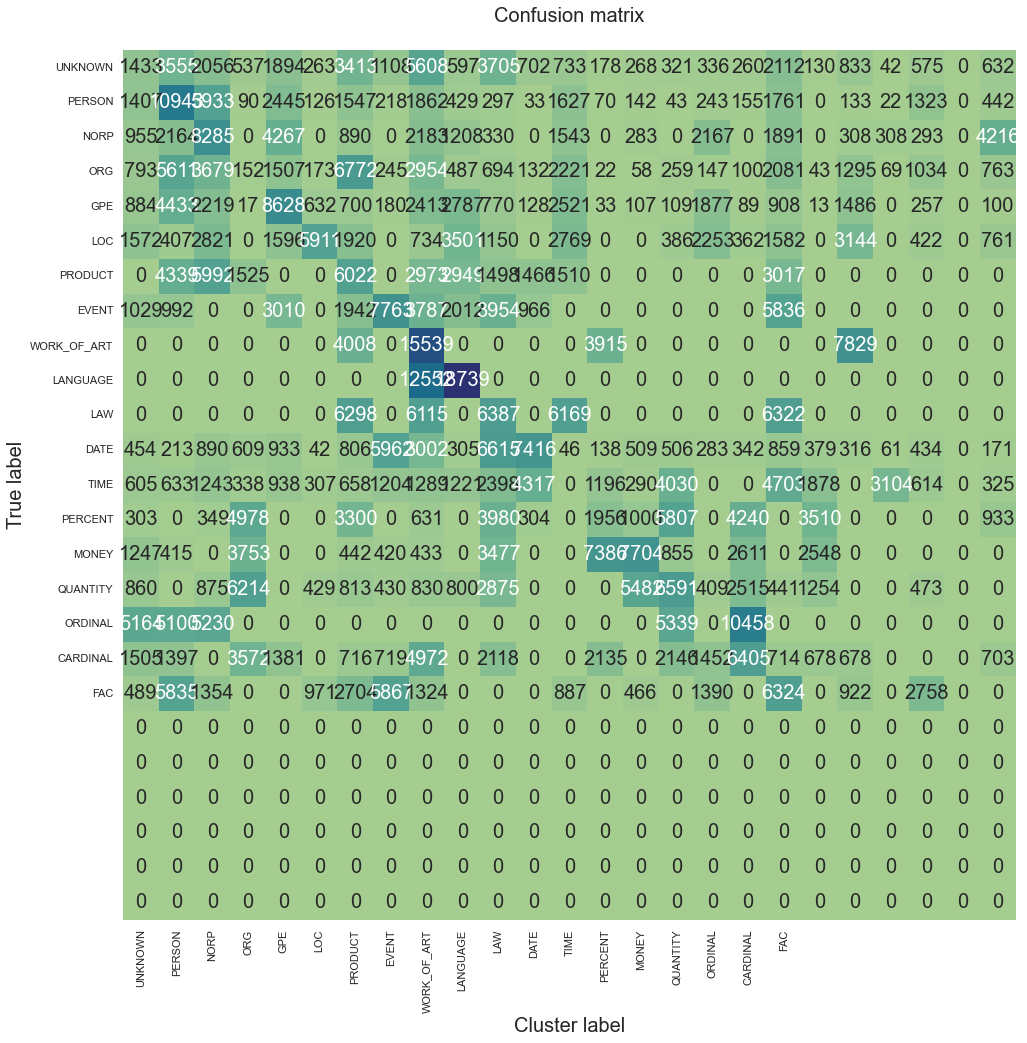

CLUSTERS


100%|██████████| 25/25 [00:00<00:00, 135.87it/s]


14: "UNK-16 Was ORDINAL", 18700 items, (27.61% confidence)
15: "UNK-15 Was QUANTITY", 26392 items, (24.97% confidence)
17: "UNK-13 Was DATE", 40248 items, (16.44% confidence)
19: "UNK-14", 0 items, (0.00% confidence)
No words for cluster {'freqs': {}, 'frac': 0, 'n': 0, 'name': 'UNK-14', 'idx': 14}
0: "TIME", 3606 items, (86.08% confidence)
1: "LOC", 8854 items, (66.76% confidence)
2: "LANGUAGE", 35035 items, (53.49% confidence)
3: "DATE", 15464 items, (47.96% confidence)
4: "MONEY", 16309 items, (47.24% confidence)
5: "NORP", 9046 items, (46.61% confidence)
6: "WORK_OF_ART", 16944 items, (46.21% confidence)
7: "ORDINAL", 27537 items, (37.98% confidence)
8: "FAC", 8183 items, (33.70% confidence)
9: "PERCENT", 10433 items, (33.64% confidence)
10: "GPE", 26599 items, (32.44% confidence)
11: "EVENT", 24116 items, (32.19% confidence)
12: "LAW", 20026 items, (30.80% confidence)
13: "QUANTITY", 21785 items, (28.52% confidence)
16: "PERSON", 46037 items, (23.77% confidence)
18: "ORG", 42951 i

In [20]:

dc = DeepCluster('test-0-40latent', dims=[768, 500, 500, 2000, 40],
    entity_count=10, train_size=0, num_clusters=25).train_and_evaluate_model(10000)

In [ ]:
dc = DeepCluster('test1', train_size=0, num_clusters=25).train_and_evaluate_model(10000)

In [ ]:
# %history -g -f jupyter_history3.py

In [ ]:
make_data(10000, oversample=False)
"Done"

In [ ]:
dc = DeepCluster('test-0', entity_count=10, train_size=0, num_clusters=25).train_and_evaluate_model(10000)


Load Data
Loading ./data/conll_spacy_0.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Done: (9153, 772)
Train data balance:
[[   2 2080]
 [   3  142]
 [   4 1950]
 [   5 2664]
 [   6  114]
 [  12 1659]
 [  13  143]
 [  14  151]
 [  15  111]
 [  16  139]]
Balancing data


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (26640, 768), y: (26640,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Data Loaded
Training autoencoder
Epoch 48: early stopping
Trained autoencoder


cluster init
4/4 [==============================] - 0s 1ms/step
cluster init done


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Iter: 0 Acc = 0.26745, nmi = 0.24868, ari = 0.11393 ; loss=0


C:\Users\Will\AppData\Local\Temp\ipykernel_27336\1454222060.py:180: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  delta_label = np.sum(y_pred != self.y_pred_last).astype(


Iter: 140 Acc = 0.27586, nmi = 0.25738, ari = 0.12401 ; loss=[0.02318 0.01497 0.01869]
Iter: 280 Acc = 0.27857, nmi = 0.26511, ari = 0.12994 ; loss=[0.01467 0.02543 0.00704]
Iter: 420 Acc = 0.29185, nmi = 0.26390, ari = 0.13622 ; loss=[0.02021 0.03869 0.0086 ]
Iter: 560 Acc = 0.29985, nmi = 0.27889, ari = 0.14657 ; loss=[0.06907 0.09328 0.04108]
Iter: 700 Acc = 0.30537, nmi = 0.28702, ari = 0.15320 ; loss=[0.07831 0.14794 0.03393]
Iter: 840 Acc = 0.29917, nmi = 0.28408, ari = 0.14819 ; loss=[0.05574 0.06876 0.03511]
Iter: 980 Acc = 0.29557, nmi = 0.28660, ari = 0.14722 ; loss=[0.12513 0.20296 0.06424]
Iter: 1120 Acc = 0.29185, nmi = 0.28772, ari = 0.14753 ; loss=[0.07562 0.08351 0.05057]
Iter: 1260 Acc = 0.28953, nmi = 0.28930, ari = 0.14506 ; loss=[0.07049 0.08396 0.04531]
Iter: 1400 Acc = 0.28998, nmi = 0.29003, ari = 0.14594 ; loss=[0.12747 0.17824 0.074  ]
Iter: 1540 Acc = 0.28679, nmi = 0.29133, ari = 0.14474 ; loss=[0.08179 0.09168 0.05429]
Iter: 1680 Acc = 0.28851, nmi = 0.29082

c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (594529, 768), y: (594529,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LANGUAGE', 10: 'LAW', 11: 'DATE', 12: 'TIME', 13: 'PERCENT', 14: 'MONEY', 15: 'QUANTITY', 16: 'ORDINAL', 17: 'CARDINAL', 18: 'FAC'}
Data Loaded
Loading AE weights from ./results/test-0\jae_weights.h5
Loading model weights from ./results/test-0\DEC_model_final.h5
Predicting...
18580/18580 [==============================] - 16s 876us/step
Evaluating...
Acc = 0.26395, nmi = 0.29786, ari = 0.11213 ; loss=0.0


CLUSTERS


100%|██████████| 25/25 [00:00<00:00, 138.89it/s]


6: "UNK-19 Was TIME", 12404 items, (39.95% confidence)
8: "UNK-21 Was MONEY", 21313 items, (38.27% confidence)
9: "UNK-16 Was MONEY", 1266 items, (33.97% confidence)
13: "UNK-17 Was ORDINAL", 33567 items, (30.77% confidence)
15: "UNK-12 Was PERCENT", 27643 items, (27.21% confidence)
21: "UNK-22 Was ORDINAL", 56833 items, (18.16% confidence)
0: "TIME", 3277 items, (94.72% confidence)
1: "MONEY", 8591 items, (75.94% confidence)
2: "DATE", 15891 items, (72.34% confidence)
3: "PERCENT", 10173 items, (70.54% confidence)
4: "LOC", 2508 items, (60.57% confidence)
5: "LANGUAGE", 13822 items, (45.17% confidence)
7: "QUANTITY", 33734 items, (39.18% confidence)
10: "GPE", 31827 items, (32.43% confidence)
11: "ORDINAL", 16750 items, (31.87% confidence)
12: "FAC", 43548 items, (31.09% confidence)
14: "EVENT", 30310 items, (29.20% confidence)
16: "PERSON", 45591 items, (25.97% confidence)
17: "ORG", 39795 items, (24.82% confidence)
18: "NORP", 14151 items, (23.81% confidence)
19: "WORK_OF_ART", 5726

Load Data
Creating data


  0%|          | 0/3 [00:00<?, ?it/s]

Reading lines


100%|██████████| 3000/3000 [00:00<00:00, 599843.26it/s]


Finished 'get_pipe' in 7.136 secs


100%|██████████| 3000/3000 [05:26<00:00,  9.18it/s]


Finished 'get_training_data_spacy' in 327.396 secs
SAVED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Done: (2038, 772)
Train data balance:
[[  2 416]
 [  3  33]
 [  4 386]
 [  5 719]
 [  6  25]
 [ 12 366]
 [ 13  30]
 [ 14  25]
 [ 15  17]
 [ 16  21]]
Balancing data


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (7190, 768), y: (7190,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Data Loaded
Training autoencoder
Epoch 52: early stopping
Trained autoencoder


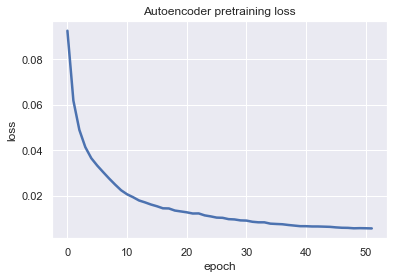

cluster init
225/225 [==============================] - 0s 603us/step
cluster init done
Iter: 0 Acc = 0.23324, nmi = 0.28842, ari = 0.11949 ; loss=0
Iter: 140 Acc = 0.24590, nmi = 0.29006, ari = 0.12922 ; loss=[0.20301 0.53188 0.04345]
Iter: 280 Acc = 0.26565, nmi = 0.30744, ari = 0.13829 ; loss=[0.07787 0.17566 0.02517]
Iter: 420 Acc = 0.28011, nmi = 0.31208, ari = 0.14400 ; loss=[0.25256 0.71721 0.0374 ]
Iter: 560 Acc = 0.28887, nmi = 0.33140, ari = 0.15737 ; loss=[0.05696 0.03419 0.0467 ]
Iter: 700 Acc = 0.29207, nmi = 0.34940, ari = 0.16530 ; loss=[0.16089 0.26401 0.08168]
Iter: 840 Acc = 0.30028, nmi = 0.36556, ari = 0.17585 ; loss=[0.04524 0.07774 0.02192]
Iter: 980 Acc = 0.30083, nmi = 0.35257, ari = 0.16561 ; loss=[0.27395 0.73669 0.05294]
Iter: 1120 Acc = 0.30111, nmi = 0.37306, ari = 0.17027 ; loss=[0.09933 0.16189 0.05076]
Iter: 1260 Acc = 0.31182, nmi = 0.38887, ari = 0.17606 ; loss=[0.1627  0.27754 0.07944]
Iter: 1400 Acc = 0.31280, nmi = 0.39380, ari = 0.18131 ; loss=[0.1

c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (594529, 768), y: (594529,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LANGUAGE', 10: 'LAW', 11: 'DATE', 12: 'TIME', 13: 'PERCENT', 14: 'MONEY', 15: 'QUANTITY', 16: 'ORDINAL', 17: 'CARDINAL', 18: 'FAC'}
Data Loaded
Loading AE weights from ./results/test-none-3k\jae_weights.h5
Loading model weights from ./results/test-none-3k\DEC_model_final.h5
Predicting...
18580/18580 [==============================] - 15s 816us/step
Evaluating...
Acc = 0.23660, nmi = 0.28380, ari = 0.08799 ; loss=0


CLUSTERS


100%|██████████| 25/25 [00:00<00:00, 127.55it/s]


5: "UNK-2 Was PERCENT", 20270 items, (62.94% confidence)
6: "UNK-13 Was MONEY", 12210 items, (59.89% confidence)
7: "UNK-7 Was QUANTITY", 3769 items, (55.77% confidence)
8: "UNK-10 Was QUANTITY", 1509 items, (55.73% confidence)
10: "UNK-19 Was TIME", 13263 items, (34.71% confidence)
13: "UNK-23 Was LANGUAGE", 39597 items, (31.56% confidence)
14: "UNK-22 Was LANGUAGE", 29082 items, (21.86% confidence)
17: "UNK-15 Was ORDINAL", 57180 items, (18.07% confidence)
19: "UNK-4 Was LAW", 130806 items, (14.37% confidence)
0: "PERCENT", 767 items, (89.05% confidence)
1: "MONEY", 5316 items, (71.48% confidence)
2: "LOC", 3950 items, (68.51% confidence)
3: "QUANTITY", 7364 items, (66.74% confidence)
4: "TIME", 6350 items, (63.24% confidence)
9: "DATE", 28286 items, (47.71% confidence)
11: "LANGUAGE", 18042 items, (34.61% confidence)
12: "ORDINAL", 32979 items, (31.71% confidence)
15: "PRODUCT", 21320 items, (21.23% confidence)
16: "GPE", 37868 items, (19.52% confidence)
18: "LAW", 69439 items, (17.

In [ ]:
train_and_evaluate_model('test-none-3k', train_size=3000, eval_size=10000, n_clusters=25, entity_count=10)


Load Data
Loading ./data/conll_spacy_10000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Done: (37748, 772)
Train data balance:
[[    1 31291]
 [    2  1454]
 [    3   102]
 [    4  1344]
 [    5  1842]
 [    6    80]
 [    7    21]
 [    8    32]
 [    9     8]
 [   10     5]
 [   11     5]
 [   12  1100]
 [   13   101]
 [   14    96]
 [   15    73]
 [   16    75]
 [   17     6]
 [   18    44]
 [   19    69]]
Balancing data


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (594529, 768), y: (594529,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LANGUAGE', 10: 'LAW', 11: 'DATE', 12: 'TIME', 13: 'PERCENT', 14: 'MONEY', 15: 'QUANTITY', 16: 'ORDINAL', 17: 'CARDINAL', 18: 'FAC'}
Data Loaded


Predicting...
18580/18580 [==============================] - 17s 886us/step
Evaluating...
Acc = 0.23660, nmi = 0.28380, ari = 0.08799 ; loss=0.0


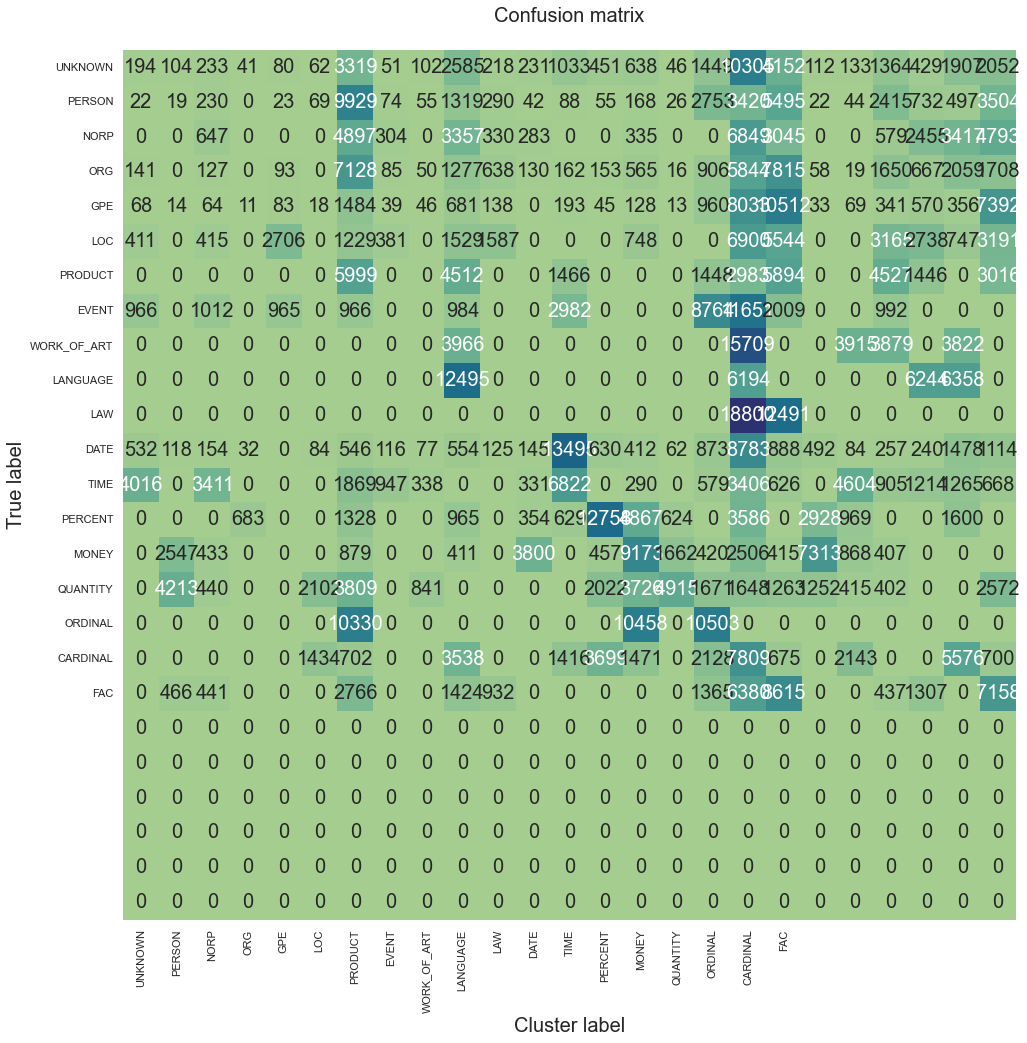

CLUSTERS


100%|██████████| 25/25 [00:00<00:00, 121.95it/s]


5: "UNK-2 Was PERCENT", 20270 items, (62.94% confidence)
6: "UNK-13 Was MONEY", 12210 items, (59.89% confidence)
7: "UNK-7 Was QUANTITY", 3769 items, (55.77% confidence)
8: "UNK-10 Was QUANTITY", 1509 items, (55.73% confidence)
10: "UNK-19 Was TIME", 13263 items, (34.71% confidence)
13: "UNK-23 Was LANGUAGE", 39597 items, (31.56% confidence)
14: "UNK-22 Was LANGUAGE", 29082 items, (21.86% confidence)
17: "UNK-15 Was ORDINAL", 57180 items, (18.07% confidence)
19: "UNK-4 Was LAW", 130806 items, (14.37% confidence)
0: "PERCENT", 767 items, (89.05% confidence)
1: "MONEY", 5316 items, (71.48% confidence)
2: "LOC", 3950 items, (68.51% confidence)
3: "QUANTITY", 7364 items, (66.74% confidence)
4: "TIME", 6350 items, (63.24% confidence)
9: "DATE", 28286 items, (47.71% confidence)
11: "LANGUAGE", 18042 items, (34.61% confidence)
12: "ORDINAL", 32979 items, (31.71% confidence)
15: "PRODUCT", 21320 items, (21.23% confidence)
16: "GPE", 37868 items, (19.52% confidence)
18: "LAW", 69439 items, (17.

In [ ]:
model = evaluate_model('test-none-3k', eval_size=10000, n_clusters=25)


In [ ]:

serialise_model(model, 'test-none-3k')

Serialising model weights to ./results/test-none-3k


INFO:tensorflow:Assets written to: ./results/test-none-3k\assets


INFO:tensorflow:Assets written to: ./results/test-none-3k\assets


In [ ]:
models.load_model('./results/test-none-3k')

Load Data
Loading ./data/conll_spacy_10000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Done: (6267, 772)
Train data balance:
[[   2 1454]
 [   3  102]
 [   4 1344]
 [   5 1842]
 [   6   80]
 [  12 1100]
 [  13  101]
 [  14   96]
 [  15   73]
 [  16   75]]


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (18420, 768), y: (18420,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Data Loaded
Training autoencoder
Epoch 57: early stopping
Trained autoencoder


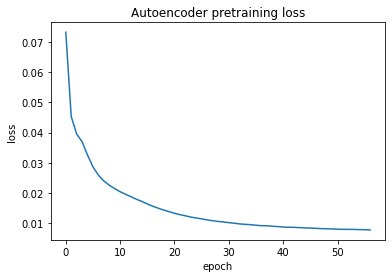

cluster init
4/4 [==============================] - 0s 667us/step
cluster init done


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Iter 0: acc = 0.24794, nmi = 0.23884, ari = 0.10780  ; loss= 0


C:\Users\Will\AppData\Local\Temp\ipykernel_9968\1984266305.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  delta_label = np.sum(y_pred != y_pred_last).astype(


Iter 140: acc = 0.25375, nmi = 0.24981, ari = 0.11498  ; loss= [0.00595 0.01293 0.00207]
Iter 280: acc = 0.25326, nmi = 0.26282, ari = 0.12263  ; loss= [0.0134  0.02537 0.00579]
Iter 420: acc = 0.26287, nmi = 0.27492, ari = 0.12807  ; loss= [0.03416 0.0636  0.01508]
Iter 560: acc = 0.27068, nmi = 0.28721, ari = 0.13537  ; loss= [0.05314 0.09171 0.02562]
Iter 700: acc = 0.26824, nmi = 0.28484, ari = 0.13380  ; loss= [0.08064 0.13666 0.03964]
Iter 840: acc = 0.26878, nmi = 0.29003, ari = 0.13411  ; loss= [0.08711 0.1393  0.04531]
Iter 980: acc = 0.26813, nmi = 0.29255, ari = 0.13530  ; loss= [0.15552 0.26134 0.07712]
Iter 1120: acc = 0.26694, nmi = 0.29851, ari = 0.13805  ; loss= [0.09197 0.13242 0.05225]
Iter 1260: acc = 0.26683, nmi = 0.29953, ari = 0.13876  ; loss= [0.1427  0.22352 0.07565]
Iter 1400: acc = 0.26754, nmi = 0.29883, ari = 0.13882  ; loss= [0.10649 0.13381 0.06634]
Iter 1540: acc = 0.26602, nmi = 0.29951, ari = 0.13857  ; loss= [0.12598 0.14651 0.08203]
Iter 1680: acc = 

In [ ]:
train_model('test-none-10k', train_size=10000, n_clusters=25, entity_count=10)


In [ ]:
evaluate_model('test-none-10k', eval_size=10000, n_clusters=25)


Load Data
Loading ./data/conll_spacy_10000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Done: (37748, 772)
Train data balance:
[[    1 31291]
 [    2  1454]
 [    3   102]
 [    4  1344]
 [    5  1842]
 [    6    80]
 [    7    21]
 [    8    32]
 [    9     8]
 [   10     5]
 [   11     5]
 [   12  1100]
 [   13   101]
 [   14    96]
 [   15    73]
 [   16    75]
 [   17     6]
 [   18    44]
 [   19    69]]


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (594529, 768), y: (594529,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LANGUAGE', 10: 'LAW', 11: 'DATE', 12: 'TIME', 13: 'PERCENT', 14: 'MONEY', 15: 'QUANTITY', 16: 'ORDINAL', 17: 'CARDINAL', 18: 'FAC'}
Data Loaded
Loading AE weights from ./results/test-none-10k\jae_weights.h5
Loading model weights from ./results/test-none-10k\DEC_model_final.h5
Predicting...
18580/18580 [==============================] - 15s 808us/step
Evaluating...
Acc = 0.24264, nmi = 0.30550, ari = 0.11430  ; loss= 0


CLUSTERS


100%|██████████| 25/25 [00:00<00:00, 138.12it/s]


3: "UNK-21 Was QUANTITY", 10011 items, (46.30% confidence)
13: "UNK-13 Was TIME", 27574 items, (28.13% confidence)
14: "UNK-23 Was PERCENT", 6399 items, (25.69% confidence)
16: "UNK-22 Was LANGUAGE", 27268 items, (22.93% confidence)
17: "UNK-24 Was FAC", 25219 items, (21.44% confidence)
19: "UNK-12 Was LAW", 80746 items, (15.71% confidence)
0: "DATE", 19317 items, (57.44% confidence)
1: "MONEY", 8005 items, (53.63% confidence)
2: "QUANTITY", 12429 items, (48.72% confidence)
4: "EVENT", 34236 items, (45.86% confidence)
5: "LANGUAGE", 13841 items, (45.11% confidence)
6: "GPE", 19353 items, (42.45% confidence)
7: "TIME", 2501 items, (37.19% confidence)
8: "PERCENT", 30629 items, (36.23% confidence)
9: "FAC", 30906 items, (30.71% confidence)
10: "ORDINAL", 34513 items, (29.93% confidence)
11: "LAW", 20916 items, (29.49% confidence)
12: "LOC", 9118 items, (28.71% confidence)
15: "NORP", 18989 items, (23.94% confidence)
18: "WORK_OF_ART", 37206 items, (20.70% confidence)
... wrote results  <

: 

In [ ]:
evaluate_model('test-none-30', train_size=30, eval_size=1000, n_clusters=25)


Load Data
Loading ./data/conll_spacy_1000.pkl
LOADED {1: 'UNKNOWN', 3: 'ORG', 2: 'PERSON', 7: 'DATE', 4: 'GPE', 5: 'LOC', 10: 'QUANTITY', 8: 'PERCENT', 6: 'EVENT', 9: 'MONEY'}
Done: (3348, 772)
Train data balance:
[[  2 153]
 [  3   7]
 [  4 122]
 [  5 249]
 [  6   7]
 [  7   1]
 [  8   5]
 [  9 103]
 [ 10   2]
 [ 11   3]
 [ 12   7]
 [ 13   5]
 [ 14   3]
 [ 15   1]
 [ 16   8]]


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (3735, 768), y: (3735,)


KeyError: 11

In [ ]:
train_and_evaluate_model('test3', train_size=1000, eval_size=10000, n_clusters=25, entity_count=10)


TypeError: make_model() got an unexpected keyword argument 'data_rows'

In [ ]:
train_and_evaluate_model('test1', train_size=10000, eval_size=10000, n_clusters=25, entity_count=0)

Load Data
Loading ./data/conll_spacy_10000.pkl
Done: (6452, 772)
Train data balance:
[[   2 1454]
 [   3  102]
 [   4 1344]
 [   5 1842]
 [   6   80]
 [   7   21]
 [   8   32]
 [   9    8]
 [  10    5]
 [  12 1100]
 [  13  101]
 [  14   96]
 [  15   73]
 [  16   75]
 [  17    6]
 [  18   44]
 [  19   69]]


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (31314, 768), y: (31314,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'WORK_OF_ART', 8: 'LANGUAGE', 9: 'DATE', 10: 'TIME', 11: 'PERCENT', 12: 'MONEY', 13: 'QUANTITY', 14: 'ORDINAL', 15: 'CARDINAL', 16: 'FAC'}
Data Loaded
Training autoencoder
Epoch 38: early stopping
Trained autoencoder


cluster init
4/4 [==============================] - 0s 1ms/step
cluster init done


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Iter 0: acc = 0.26068, nmi = 0.31469, ari = 0.12918  ; loss= 0


C:\Users\Will\AppData\Local\Temp\ipykernel_14532\1984266305.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  delta_label = np.sum(y_pred != y_pred_last).astype(


Iter 140: acc = 0.25554, nmi = 0.31130, ari = 0.12105  ; loss= [0.02644 0.01961 0.02056]
Iter 280: acc = 0.25835, nmi = 0.30652, ari = 0.12008  ; loss= [0.01912 0.02271 0.0123 ]
Iter 420: acc = 0.26726, nmi = 0.31156, ari = 0.12478  ; loss= [0.02586 0.05019 0.01081]
Iter 560: acc = 0.26621, nmi = 0.31893, ari = 0.13058  ; loss= [0.01595 0.02995 0.00696]
Iter 700: acc = 0.28071, nmi = 0.32150, ari = 0.13462  ; loss= [0.06072 0.07105 0.03941]
Iter 840: acc = 0.28601, nmi = 0.32870, ari = 0.13839  ; loss= [0.0943  0.08916 0.06755]
Iter 980: acc = 0.27726, nmi = 0.32705, ari = 0.13620  ; loss= [0.11414 0.15468 0.06774]
Iter 1120: acc = 0.28055, nmi = 0.33323, ari = 0.13733  ; loss= [0.12335 0.11672 0.08833]
Iter 1260: acc = 0.28128, nmi = 0.33316, ari = 0.13883  ; loss= [0.12243 0.13592 0.08166]
Iter 1400: acc = 0.28629, nmi = 0.33280, ari = 0.13952  ; loss= [0.07403 0.07023 0.05296]
Iter 1540: acc = 0.28387, nmi = 0.33333, ari = 0.14084  ; loss= [0.12065 0.2035  0.0596 ]
Iter 1680: acc = 

c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (33156, 768), y: (33156,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'WORK_OF_ART', 8: 'LANGUAGE', 9: 'LAW', 10: 'DATE', 11: 'TIME', 12: 'PERCENT', 13: 'MONEY', 14: 'QUANTITY', 15: 'ORDINAL', 16: 'CARDINAL', 17: 'FAC'}
Data Loaded
Loading AE weights from ./results/test1\jae_weights.h5
Loading model weights from ./results/test1\DEC_model_final.h5
Predicting...
1037/1037 [==============================] - 1s 868us/step
Evaluating...
Acc = 0.28058, nmi = 0.34448, ari = 0.14007  ; loss= 0


CLUSTERS


100%|██████████| 25/25 [00:00<00:00, 1315.64it/s]

4: "UNK-17 Was LANGUAGE", 784 items, (50.13% confidence)


7: "UNK-8 Was ORDINAL", 1423 items, (43.01% confidence)
13: "UNK-22 Was CARDINAL", 1476 items, (31.57% confidence)
18: "UNK-19 Was LAW", 2935 items, (24.87% confidence)
19: "UNK-14 Was MONEY", 2659 items, (21.74% confidence)
20: "UNK-23 Was PERSON", 1246 items, (18.14% confidence)
0: "ORDINAL", 325 items, (100.00% confidence)
1: "LANGUAGE", 788 items, (92.51% confidence)
2: "WORK_OF_ART", 270 items, (90.00% confidence)
3: "EVENT", 786 items, (51.15% confidence)
5: "FAC", 1367 items, (49.82% confidence)
6: "MONEY", 1511 items, (46.06% confidence)
8: "CARDINAL", 1631 items, (39.61% confidence)
9: "DATE", 2203 items, (38.95% confidence)
10: "PRODUCT", 405 items, (37.78% confidence)
11: "TIME", 955 items, (37.38% confidence)
12: "PERCENT", 1369 items, (35.79% confidence)
14: "PERSON", 1865 items, (30.94% confidence)
15: "LOC", 1624 items, (30.17% confidence)
16: "GPE", 1402 items, (29.89% confidence)
17: "LAW", 2497 items, (29.64% confidence)
... wrote results  <a href="c:\Users\Will\Proje

Load Data
Loading ./data/conll_spacy_10000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Done: (6452, 772)
Train data balance:
[[   2 1454]
 [   3  102]
 [   4 1344]
 [   5 1842]
 [   6   80]
 [   7   21]
 [   8   32]
 [   9    8]
 [  10    5]
 [  12 1100]
 [  13  101]
 [  14   96]
 [  15   73]
 [  16   75]
 [  17    6]
 [  18   44]
 [  19   69]]


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (31314, 768), y: (31314,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'WORK_OF_ART', 8: 'LANGUAGE', 9: 'DATE', 10: 'TIME', 11: 'PERCENT', 12: 'MONEY', 13: 'QUANTITY', 14: 'ORDINAL', 15: 'CARDINAL', 16: 'FAC'}
Data Loaded
Data Loaded
Training autoencoder
Epoch 39: early stopping
Trained autoencoder


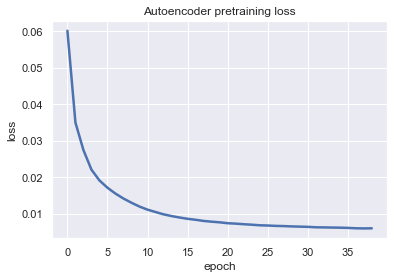

cluster init
4/4 [==============================] - 0s 1ms/step
cluster init done


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Iter: 0 Acc = 0.24273, nmi = 0.27968, ari = 0.10747 ; loss=0


C:\Users\Will\AppData\Local\Temp\ipykernel_28380\3164145499.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  delta_label = np.sum(y_pred != y_pred_last).astype(


Iter: 140 Acc = 0.24242, nmi = 0.28555, ari = 0.11064 ; loss=[0.02511 0.01497 0.02062]
Iter: 280 Acc = 0.23536, nmi = 0.29147, ari = 0.11528 ; loss=[0.01912 0.02294 0.01224]
Iter: 420 Acc = 0.24580, nmi = 0.30538, ari = 0.11936 ; loss=[0.02458 0.04706 0.01046]
Iter: 560 Acc = 0.24666, nmi = 0.29972, ari = 0.10569 ; loss=[0.02795 0.05862 0.01036]
Iter: 700 Acc = 0.25318, nmi = 0.31061, ari = 0.11542 ; loss=[0.09112 0.15371 0.04501]
Iter: 840 Acc = 0.25008, nmi = 0.31194, ari = 0.11763 ; loss=[0.12562 0.17156 0.07415]
Iter: 980 Acc = 0.24791, nmi = 0.31380, ari = 0.12240 ; loss=[0.09471 0.09867 0.06511]
Iter: 1120 Acc = 0.25049, nmi = 0.31828, ari = 0.12294 ; loss=[0.11526 0.11196 0.08167]
Iter: 1260 Acc = 0.25257, nmi = 0.32467, ari = 0.12524 ; loss=[0.09999 0.09307 0.07207]
Iter: 1400 Acc = 0.24919, nmi = 0.32230, ari = 0.12656 ; loss=[0.08152 0.07559 0.05884]
Iter: 1540 Acc = 0.25110, nmi = 0.32081, ari = 0.12439 ; loss=[0.10464 0.16199 0.05604]
Iter: 1680 Acc = 0.24545, nmi = 0.32054

TypeError: evaluate_model() got an unexpected keyword argument 'data_rows'

In [ ]:
train_and_evaluate_model('test1-2', train_size=10000, eval_size=10000, n_clusters=25, entity_count=0)

In [ ]:
evaluate_model('test1-2', eval_size=10000, n_clusters=25, include_unclass=True)

Load Data
Loading ./data/conll_spacy_10000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Done: (37748, 772)
Train data balance:
[[    1 31291]
 [    2  1454]
 [    3   102]
 [    4  1344]
 [    5  1842]
 [    6    80]
 [    7    21]
 [    8    32]
 [    9     8]
 [   10     5]
 [   11     5]
 [   12  1100]
 [   13   101]
 [   14    96]
 [   15    73]
 [   16    75]
 [   17     6]
 [   18    44]
 [   19    69]]
Balancing data


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (594529, 768), y: (594529,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LANGUAGE', 10: 'LAW', 11: 'DATE', 12: 'TIME', 13: 'PERCENT', 14: 'MONEY', 15: 'QUANTITY', 16: 'ORDINAL', 17: 'CARDINAL', 18: 'FAC'}
Data Loaded
Loading AE weights from ./results/test1-2\jae_weights.h5
Loading model weights from ./results/test1-2\DEC_model_final.h5
Predicting...
18580/18580 [==============================] - 15s 805us/step
Evaluating...
Acc = 0.23719, nmi = 0.31933, ari = 0.12033 ; loss=0


CLUSTERS


100%|██████████| 25/25 [00:00<00:00, 137.37it/s]


3: "UNK-10 Was LANGUAGE", 11606 items, (53.80% confidence)
7: "UNK-23 Was ORDINAL", 13986 items, (37.39% confidence)
12: "UNK-17 Was LOC", 13682 items, (28.35% confidence)
13: "UNK-20 Was DATE", 23277 items, (27.04% confidence)
14: "UNK-22 Was ORDINAL", 19633 items, (26.30% confidence)
16: "UNK-19 Was LAW", 28403 items, (22.17% confidence)
17: "UNK-8 Was LOC", 26576 items, (18.85% confidence)
20: "UNK-21 Was FAC", 30696 items, (17.63% confidence)
21: "UNK-11 Was MONEY", 44564 items, (15.34% confidence)
0: "WORK_OF_ART", 8119 items, (96.43% confidence)
1: "LANGUAGE", 13423 items, (92.65% confidence)
2: "ORDINAL", 15512 items, (67.42% confidence)
4: "DATE", 19144 items, (50.54% confidence)
5: "LOC", 12059 items, (44.83% confidence)
6: "CARDINAL", 23015 items, (39.51% confidence)
8: "LAW", 16825 items, (36.34% confidence)
9: "MONEY", 31954 items, (33.78% confidence)
10: "PERCENT", 47141 items, (32.39% confidence)
11: "FAC", 20351 items, (30.83% confidence)
15: "NORP", 27918 items, (23.30%

In [ ]:
train_model('test1', cluster="GMM", data_rows=1000, entity_count=0, n_clusters=20 )

Load Data
Loading ./data/conll_spacy_1000.pkl
Done: (676, 772)
Train data balance:
[[  2 153]
 [  3   7]
 [  4 122]
 [  5 249]
 [  6   7]
 [  7   1]
 [  8   5]
 [  9 103]
 [ 10   2]
 [ 11   3]
 [ 12   7]
 [ 13   5]
 [ 14   3]
 [ 15   1]
 [ 16   8]]
x: (3735, 768), y: (3735,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'DATE', 8: 'TIME', 9: 'PERCENT', 10: 'MONEY', 11: 'QUANTITY', 12: 'ORDINAL', 13: 'CARDINAL', 14: 'FAC'}
Data Loaded
Training autoencoder


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Epoch 60: early stopping
Trained autoencoder


cluster init
117/117 [==============================] - 0s 552us/step


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(


cluster init done
Iter 0: acc = 0.49183, nmi = 0.58137, ari = 0.37034  ; loss= 0
Iter 140: acc = 0.06667, nmi = 0.00000, ari = 0.00000  ; loss= [0.61221 0.73023 0.39314]
Iter 280: acc = 0.06667, nmi = 0.00000, ari = 0.00000  ; loss= [ 0.57873 -0.       0.57873]
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.
Training Done


Load Data
Loading ./data/conll_spacy_1000.pkl
Done: (2218, 772)
Splitting
Train data balance:
Most frequent words: 
      entity  freq
0        GPE   464
1     PERSON   445
2   CARDINAL   410
3        ORG   292
4       DATE   267
5       NORP   146
6    ORDINAL    70
7       TIME    31
8        FAC    17
9      EVENT    16
10   PERCENT    14
11     MONEY    13
12       LOC    12
13  QUANTITY    12
14  LANGUAGE     5
15   PRODUCT     4
Resampling


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Drop unused
Split complete
x: (7424, 768), y: (7424,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'LANGUAGE', 8: 'DATE', 9: 'TIME', 10: 'PERCENT', 11: 'MONEY', 12: 'QUANTITY', 13: 'ORDINAL', 14: 'CARDINAL', 15: 'FAC'}
Data Loaded
Training autoencoder
Epoch 62: early stopping
Trained autoencoder


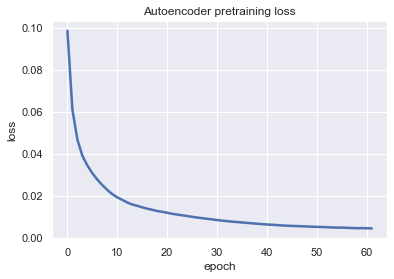

cluster init
232/232 [==============================] - 0s 528us/step
cluster init done
Iter 0: acc = 0.24192, nmi = 0.31372, ari = 0.12822  ; loss= 0
Iter 140: acc = 0.25445, nmi = 0.32094, ari = 0.12345  ; loss= [0.1573  0.31077 0.06407]
Iter 280: acc = 0.26131, nmi = 0.33726, ari = 0.13414  ; loss= [0.1247  0.17715 0.07155]
Iter 420: acc = 0.26387, nmi = 0.33861, ari = 0.13129  ; loss= [0.13401 0.20704 0.0719 ]
Iter 560: acc = 0.25337, nmi = 0.34556, ari = 0.13052  ; loss= [0.1285  0.18963 0.07162]
Iter 700: acc = 0.26064, nmi = 0.36227, ari = 0.14257  ; loss= [0.13537 0.20985 0.07242]
Iter 840: acc = 0.25620, nmi = 0.36429, ari = 0.14137  ; loss= [0.13283 0.2021  0.0722 ]
Iter 980: acc = 0.27640, nmi = 0.37389, ari = 0.14758  ; loss= [0.14393 0.23342 0.0739 ]
Iter 1120: acc = 0.27613, nmi = 0.37780, ari = 0.14796  ; loss= [0.14545 0.23301 0.07555]
Iter 1260: acc = 0.27263, nmi = 0.37819, ari = 0.14661  ; loss= [0.15308 0.25267 0.07728]
Iter 1400: acc = 0.27586, nmi = 0.38241, ari =

In [ ]:
train_model('test1', cluster="GMM", data_rows=1000, entity_count=0, n_clusters=20 )


In [ ]:
evaluate_model('test1', data_rows=1000, n_clusters=20 )

Load Data
Loading ./data/conll_spacy_1000.pkl
Done: (3348, 772)
Train data balance:
[[  2 153]
 [  3   7]
 [  4 122]
 [  5 249]
 [  6   7]
 [  7   1]
 [  8   5]
 [  9 103]
 [ 10   2]
 [ 11   3]
 [ 12   7]
 [ 13   5]
 [ 14   3]
 [ 15   1]
 [ 16   8]]


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (3735, 768), y: (3735,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'DATE', 8: 'TIME', 9: 'PERCENT', 10: 'MONEY', 11: 'QUANTITY', 12: 'ORDINAL', 13: 'CARDINAL', 14: 'FAC'}
Data Loaded
Loading AE weights from ./results/test1\jae_weights.h5
Loading model weights from ./results/test1\DEC_model_final.h5
Predicting...
117/117 [==============================] - 0s 2ms/step
Evaluating...
Acc = 0.46051, nmi = 0.59422, ari = 0.35142  ; loss= 0


CLUSTERS


100%|██████████| 20/20 [00:00<00:00, 1541.09it/s]

9: "UNK-4 Was PERCENT", 241 items, (69.71% confidence)
14: "UNK-15 Was GPE", 556 items, (28.78% confidence)


15: "UNK-18 Was FAC", 382 items, (22.77% confidence)
16: "UNK-16", 0 items, (0.00% confidence)
No words for cluster {'freqs': {}, 'frac': 0, 'n': 0, 'name': 'UNK-16', 'idx': 13}
0: "PERCENT", 81 items, (100.00% confidence)
1: "QUANTITY", 54 items, (100.00% confidence)
2: "DATE", 2 items, (100.00% confidence)
3: "GPE", 1 items, (100.00% confidence)
4: "MONEY", 107 items, (99.07% confidence)
5: "EVENT", 49 items, (97.96% confidence)
6: "LOC", 35 items, (91.43% confidence)
7: "PERSON", 5 items, (80.00% confidence)
8: "PRODUCT", 313 items, (79.55% confidence)
10: "TIME", 208 items, (64.42% confidence)
11: "CARDINAL", 448 items, (55.58% confidence)
12: "NORP", 318 items, (34.91% confidence)
13: "FAC", 101 items, (33.66% confidence)
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\results\test1\index.html">c:\Users\Will\Projects\MSc\project\results\test1\index.html</a>
None


Load Data
Loading ./data/conll_spacy_1000.pkl
Done: (2219, 772)
Splitting
Train data balance:
Most frequent words: 
      entity  freq
0        GPE   464
1     PERSON   445
2   CARDINAL   410
3        ORG   292
4       DATE   267
5    UNKNOWN   146
6    ORDINAL    70
7       TIME    31
8        FAC    17
9      EVENT    16
10   PERCENT    14
11     MONEY    13
12       LOC    12
13  QUANTITY    12
14  LANGUAGE     5
15   PRODUCT     4
16       LAW     1
Resampling


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Drop unused
Split complete
x: (7888, 768), y: (7888,)
{0: 'PERSON', 1: 'UNKNOWN', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'LANGUAGE', 8: 'LAW', 9: 'DATE', 10: 'TIME', 11: 'PERCENT', 12: 'MONEY', 13: 'QUANTITY', 14: 'ORDINAL', 15: 'CARDINAL', 16: 'FAC'}
Data Loaded
Loading AE weights from ./results/test1\jae_weights.h5
Loading model weights from ./results/test1\DEC_model_final.h5
Predicting...
247/247 [==============================] - 0s 841us/step
Evaluating...
Acc = 0.32657, nmi = 0.43093, ari = 0.19513  ; loss= 0


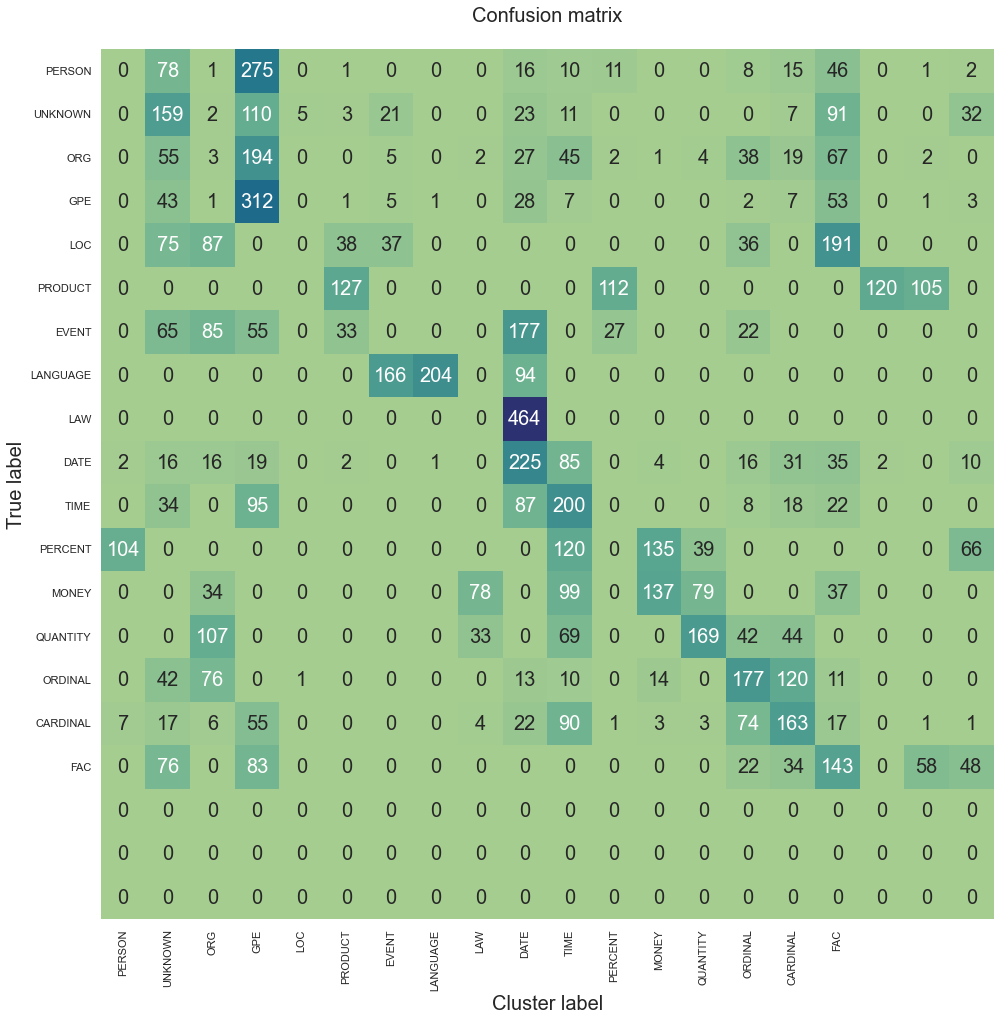

CLUSTERS


100%|██████████| 20/20 [00:00<00:00, 2000.00it/s]

3: "UNK-16", 6 items, (83.33% confidence)
4: "UNK-12 Was PRODUCT", 153 items, (73.20% confidence)


6: "UNK-14 Was PRODUCT", 205 items, (61.95% confidence)
8: "UNK-17 Was MONEY", 294 items, (46.60% confidence)
9: "UNK-4 Was PERCENT", 162 items, (40.74% confidence)
16: "UNK-3 Was QUANTITY", 418 items, (25.60% confidence)
17: "UNK-19", 660 items, (24.09% confidence)
0: "LANGUAGE", 206 items, (99.03% confidence)
1: "PRODUCT", 122 items, (98.36% confidence)
2: "PERCENT", 113 items, (92.04% confidence)
5: "MONEY", 117 items, (66.67% confidence)
7: "QUANTITY", 294 items, (57.48% confidence)
10: "ORDINAL", 445 items, (39.78% confidence)
11: "LAW", 1176 items, (39.46% confidence)
12: "CARDINAL", 458 items, (35.59% confidence)
13: "TIME", 746 items, (26.81% confidence)
14: "LOC", 713 items, (26.79% confidence)
15: "GPE", 1198 items, (26.04% confidence)
... wrote ./results/test1\index.html


In [ ]:
evaluate_model('test1', data_rows=1000, entity_count=0, n_clusters=20 )

Load Data
Loading ./data/conll_spacy_10000.pkl
Done: (6267, 772)
Splitting
Train data balance:
Most frequent words: 
     entity  freq
0       GPE  1842
1    PERSON  1454
2       ORG  1344
3      DATE  1100
4      NORP   102
5      TIME   101
6   PERCENT    96
7       LOC    80
8  QUANTITY    75
9     MONEY    73
Resampling


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Drop unused
Split complete
x: (18420, 768), y: (18420,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Training autoencoder
Epoch 51: early stopping
Trained autoencoder


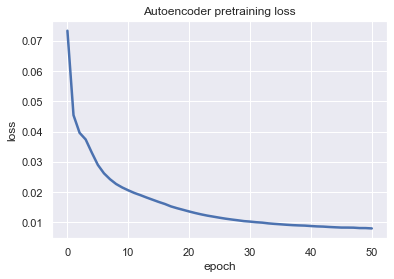

cluster init
4/4 [==============================] - 0s 667us/step
cluster init done


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Iter 0: acc = 0.28415, nmi = 0.22726, ari = 0.12453  ; loss= 0


C:\Users\Will\AppData\Local\Temp\ipykernel_17608\98579063.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  delta_label = np.sum(y_pred != y_pred_last).astype(


Iter 140: acc = 0.29142, nmi = 0.23429, ari = 0.12988  ; loss= [0.01269 0.01447 0.00835]
Iter 280: acc = 0.30233, nmi = 0.24569, ari = 0.13688  ; loss= [0.01676 0.02188 0.01019]
Iter 420: acc = 0.29919, nmi = 0.25235, ari = 0.13513  ; loss= [0.02357 0.03295 0.01368]
Iter 560: acc = 0.29501, nmi = 0.26065, ari = 0.13660  ; loss= [0.03428 0.0498  0.01934]
Iter 700: acc = 0.30022, nmi = 0.26806, ari = 0.13958  ; loss= [0.04521 0.06579 0.02547]
Iter 840: acc = 0.29881, nmi = 0.26123, ari = 0.13778  ; loss= [0.05517 0.08037 0.03106]
Iter 980: acc = 0.29967, nmi = 0.26572, ari = 0.13950  ; loss= [0.06365 0.09143 0.03622]
Iter 1120: acc = 0.30043, nmi = 0.26821, ari = 0.14004  ; loss= [0.06993 0.09836 0.04042]
Iter 1260: acc = 0.29625, nmi = 0.26728, ari = 0.13824  ; loss= [0.07482 0.10283 0.04398]
Iter 1400: acc = 0.29756, nmi = 0.26683, ari = 0.13893  ; loss= [0.07802 0.10451 0.04666]
Iter 1540: acc = 0.29479, nmi = 0.26562, ari = 0.13751  ; loss= [0.07995 0.10399 0.04876]
Iter 1680: acc = 

c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Drop unused
Split complete
x: (594529, 768), y: (594529,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LANGUAGE', 10: 'LAW', 11: 'DATE', 12: 'TIME', 13: 'PERCENT', 14: 'MONEY', 15: 'QUANTITY', 16: 'ORDINAL', 17: 'CARDINAL', 18: 'FAC'}
Data Loaded
Loading AE weights from ./results/test2\jae_weights.h5
Loading model weights from ./results/test2\DEC_model_final.h5
Predicting...
18580/18580 [==============================] - 14s 770us/step
Evaluating...
Acc = 0.26174, nmi = 0.27354, ari = 0.10982  ; loss= 0


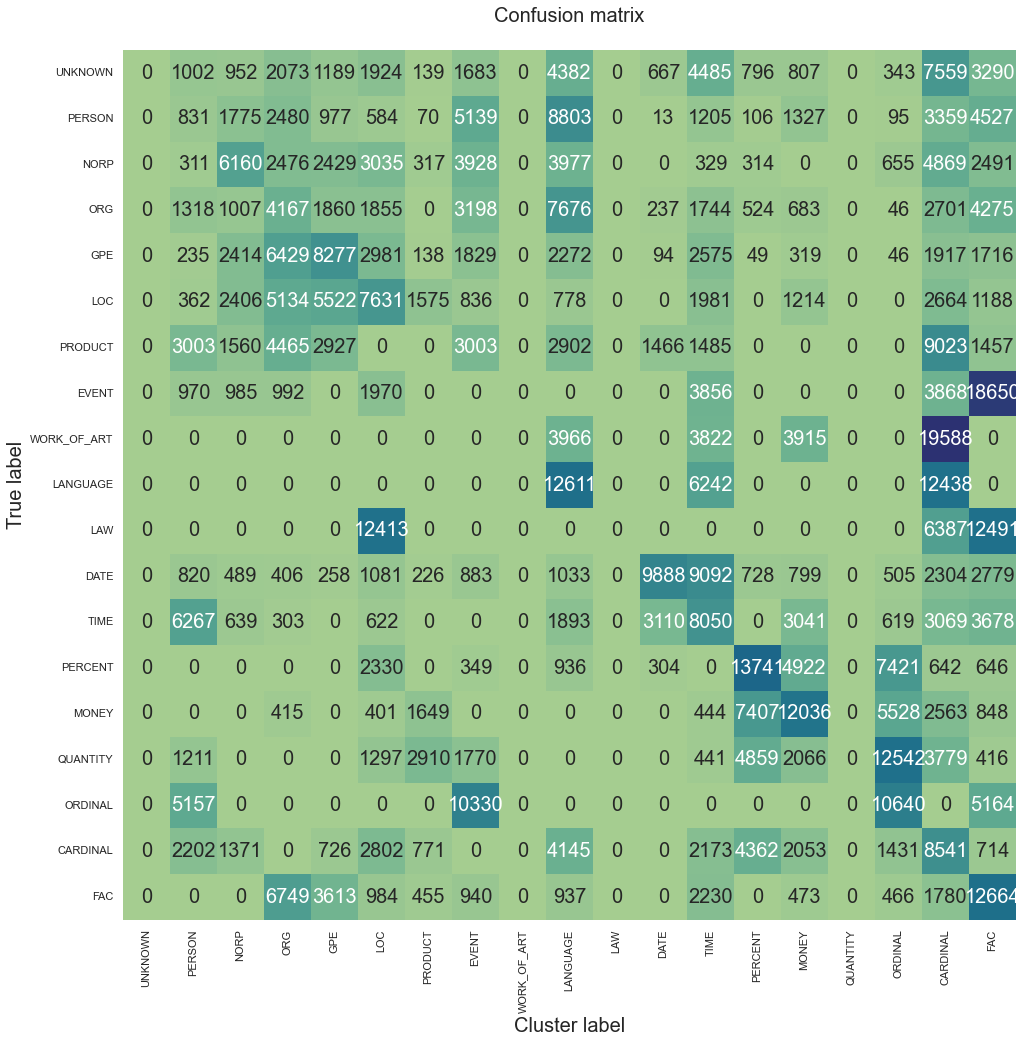

CLUSTERS


100%|██████████| 15/15 [00:00<00:00, 81.97it/s]


0: "DATE", 15779 items, (62.67% confidence)
1: "PERCENT", 32886 items, (41.78% confidence)
2: "MONEY", 33655 items, (35.76% confidence)
3: "QUANTITY", 8250 items, (35.27% confidence)
4: "NORP", 19758 items, (31.18% confidence)
5: "ORDINAL", 33888 items, (30.48% confidence)
6: "GPE", 27778 items, (29.80% confidence)
7: "LAW", 41910 items, (29.62% confidence)
8: "TIME", 23689 items, (26.46% confidence)
9: "EVENT", 76994 items, (24.22% confidence)
10: "LANGUAGE", 56311 items, (22.40% confidence)
11: "WORK_OF_ART", 97051 items, (20.18% confidence)
12: "FAC", 36089 items, (18.70% confidence)
... wrote ./results/test2\index.html


In [ ]:
train_and_evaluate_model('test2', train_size=10000, eval_size=10000, n_clusters=15, entity_count=10)

In [ ]:
train_model('reset-metrics', cluster='Kmeans', data_rows=1000, entity_count=0, n_clusters=20 )


NameError: name 'make_model' is not defined

Load Data
Loading ./data/conll_spacy_10000.pkl
Done: (6267, 772)
Splitting
Train data balance:
Most frequent words: 
     entity  freq
0       GPE  1842
1    PERSON  1454
2       ORG  1344
3      DATE  1100
4      NORP   102
5      TIME   101
6   PERCENT    96
7       LOC    80
8  QUANTITY    75
9     MONEY    73
Resampling


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Drop unused
Split complete
x: (18420, 768), y: (18420,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Training autoencoder
Epoch 1/300
72/72 [==============================] - 1s 5ms/step - loss: 0.0738
Epoch 2/300
72/72 [==============================] - 0s 2ms/step - loss: 0.0456
Epoch 3/300
72/72 [==============================] - 0s 2ms/step - loss: 0.0398
Epoch 4/300
72/72 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 5/300
72/72 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 6/300
72/72 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 7/300
72/72 [==============================] - 0s 2ms/step - loss: 0.0264
Epoch 8/300
72/72 [==============================] - 0s 2ms/step - loss: 0.0243
Epoch 9/300
72/72 [==============================] - 0s 2ms/step - loss: 0.0228
Epoch 10/300
72/72 [==============================] - 0s 2ms/step - loss:

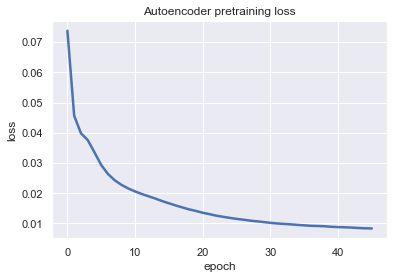

cluster init
4/4 [==============================] - 0s 1ms/step


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


cluster init done
Iter 0: acc = 0.33643, nmi = 0.26532, ari = 0.14141  ; loss= 0


C:\Users\Will\AppData\Local\Temp\ipykernel_27012\98579063.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  delta_label = np.sum(y_pred != y_pred_last).astype(


Iter 140: acc = 0.33165, nmi = 0.27398, ari = 0.15770  ; loss= [0.01281 0.01396 0.00862]
Iter 280: acc = 0.33420, nmi = 0.27615, ari = 0.16248  ; loss= [0.01755 0.02113 0.01121]
Iter 420: acc = 0.32975, nmi = 0.27889, ari = 0.16169  ; loss= [0.02879 0.03826 0.01731]
Iter 560: acc = 0.32519, nmi = 0.28581, ari = 0.16670  ; loss= [0.04254 0.05931 0.02475]
Iter 700: acc = 0.31889, nmi = 0.28603, ari = 0.16602  ; loss= [0.05602 0.08009 0.03199]
Iter 840: acc = 0.31683, nmi = 0.28870, ari = 0.16633  ; loss= [0.06857 0.10101 0.03826]
Iter 980: acc = 0.31982, nmi = 0.28869, ari = 0.16755  ; loss= [0.07683 0.1114  0.04341]
Iter 1120: acc = 0.31965, nmi = 0.28581, ari = 0.16660  ; loss= [0.08227 0.11615 0.04743]
Iter 1260: acc = 0.32584, nmi = 0.28562, ari = 0.16831  ; loss= [0.08605 0.11861 0.05046]
Iter 1400: acc = 0.31477, nmi = 0.28382, ari = 0.16434  ; loss= [0.08857 0.11924 0.0528 ]
Iter 1540: acc = 0.31536, nmi = 0.28309, ari = 0.16415  ; loss= [0.09    0.1177  0.05469]
Iter 1680: acc = 

In [ ]:
train_model('reset-metrics', cluster='Kmeans', data_rows=10000, entity_count=10, n_clusters=15 )


Load Data
Loading ./data/conll_spacy_1000.pkl
Done: (2218, 772)
Splitting
Train data balance:
Most frequent words: 
      entity  freq
0        GPE   464
1     PERSON   445
2   CARDINAL   410
3        ORG   292
4       DATE   267
5       NORP   146
6    ORDINAL    70
7       TIME    31
8        FAC    17
9      EVENT    16
10   PERCENT    14
11     MONEY    13
12       LOC    12
13  QUANTITY    12
14  LANGUAGE     5
15   PRODUCT     4
Resampling


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Drop unused
Split complete
x: (7424, 768), y: (7424,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'LANGUAGE', 8: 'DATE', 9: 'TIME', 10: 'PERCENT', 11: 'MONEY', 12: 'QUANTITY', 13: 'ORDINAL', 14: 'CARDINAL', 15: 'FAC'}
Data Loaded
Training autoencoder
Epoch 1/300
29/29 [==============================] - 1s 12ms/step - loss: 0.0969
Epoch 2/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 3/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0447
Epoch 4/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0377
Epoch 5/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 6/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0296
Epoch 7/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 8/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 9/300
29/29 [==============================] - 0s 3ms/step - l

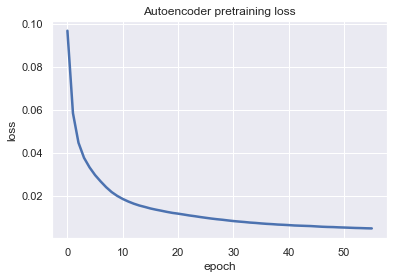

cluster init
232/232 [==============================] - 0s 745us/step
cluster init done
Iter 0: acc = 0.31910, nmi = 0.38931, ari = 0.18587  ; loss= 0
Iter 140: acc = 0.30226, nmi = 0.37354, ari = 0.17539  ; loss= [0.10497 0.15163 0.05948]
Iter 280: acc = 0.31142, nmi = 0.38645, ari = 0.18142  ; loss= [0.0957  0.0954  0.06708]
Iter 420: acc = 0.29943, nmi = 0.36818, ari = 0.16825  ; loss= [0.11121 0.13237 0.0715 ]
Iter 560: acc = 0.30307, nmi = 0.37998, ari = 0.17316  ; loss= [0.11022 0.12027 0.07414]
Iter 700: acc = 0.30321, nmi = 0.38362, ari = 0.17626  ; loss= [0.12514 0.15697 0.07805]
Iter 840: acc = 0.30294, nmi = 0.38372, ari = 0.17733  ; loss= [0.1289  0.15725 0.08172]
Iter 980: acc = 0.31115, nmi = 0.39233, ari = 0.18528  ; loss= [0.13734 0.17477 0.08491]
Iter 1120: acc = 0.31250, nmi = 0.39574, ari = 0.18573  ; loss= [0.14347 0.18463 0.08809]
Iter 1260: acc = 0.31425, nmi = 0.39834, ari = 0.18698  ; loss= [0.14882 0.19327 0.09084]
Iter 1400: acc = 0.31237, nmi = 0.39672, ari =

In [ ]:
train_model('reset-metrics-dbscan', cluster="DBSCAN", data_rows=1000, entity_count=0, n_clusters=20 )


Load Data
Loading ./data/conll_spacy_1000.pkl
Done: (1696, 772)
Splitting
Train data balance:
Most frequent words: 
     entity  freq
0       GPE   464
1    PERSON   445
2       ORG   292
3      DATE   267
4      NORP   146
5      TIME    31
6   PERCENT    14
7     MONEY    13
8       LOC    12
9  QUANTITY    12
Resampling


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Drop unused
Split complete
x: (4640, 768), y: (4640,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Training autoencoder
Epoch 1/300
19/19 [==============================] - 1s 11ms/step - loss: 0.0990
Epoch 2/300
19/19 [==============================] - 0s 2ms/step - loss: 0.0664
Epoch 3/300
19/19 [==============================] - 0s 2ms/step - loss: 0.0530
Epoch 4/300
19/19 [==============================] - 0s 2ms/step - loss: 0.0449
Epoch 5/300
19/19 [==============================] - 0s 2ms/step - loss: 0.0397
Epoch 6/300
19/19 [==============================] - 0s 2ms/step - loss: 0.0357
Epoch 7/300
19/19 [==============================] - 0s 3ms/step - loss: 0.0327
Epoch 8/300
19/19 [==============================] - 0s 3ms/step - loss: 0.0307
Epoch 9/300
19/19 [==============================] - 0s 3ms/step - loss: 0.0290
Epoch 10/300
19/19 [==============================] - 0s 2ms/step - loss: 

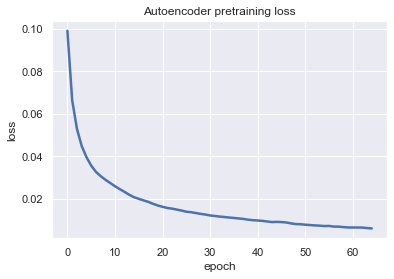

cluster init
145/145 [==============================] - 0s 750us/step


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(


cluster init done
Iter 0: acc = 0.31315, nmi = 0.32448, ari = 0.14571  ; loss= 0
Iter 140: acc = 0.31250, nmi = 0.32890, ari = 0.15218  ; loss= [0.05655 0.06224 0.03788]
Iter 280: acc = 0.31207, nmi = 0.32296, ari = 0.14953  ; loss= [0.073   0.07332 0.051  ]
Iter 420: acc = 0.32414, nmi = 0.33417, ari = 0.15951  ; loss= [0.10104 0.13051 0.06189]
Iter 560: acc = 0.34547, nmi = 0.33239, ari = 0.17408  ; loss= [0.11221 0.14423 0.06894]
Iter 700: acc = 0.34569, nmi = 0.34986, ari = 0.18005  ; loss= [0.11347 0.14172 0.07096]
Iter 840: acc = 0.34634, nmi = 0.34892, ari = 0.18161  ; loss= [0.12528 0.17553 0.07262]
Iter 980: acc = 0.34914, nmi = 0.34829, ari = 0.18591  ; loss= [0.12471 0.1717  0.07319]
Iter 1120: acc = 0.35000, nmi = 0.33503, ari = 0.17264  ; loss= [0.13684 0.21015 0.07379]
Iter 1260: acc = 0.35776, nmi = 0.34385, ari = 0.17812  ; loss= [0.13724 0.21039 0.07413]
Iter 1400: acc = 0.36078, nmi = 0.34592, ari = 0.17938  ; loss= [0.13745 0.21123 0.07408]
Iter 1540: acc = 0.35690, 

In [ ]:
train_model('reset-metrics-dbscan', cluster="DBSCAN", data_rows=1000, entity_count=10, n_clusters=15)


Load Data
Loading ./data/conll_spacy_1000.pkl
Done: (2218, 772)
Splitting
Train data balance:
Most frequent words: 
      entity  freq
0        GPE   464
1     PERSON   445
2   CARDINAL   410
3        ORG   292
4       DATE   267
5       NORP   146
6    ORDINAL    70
7       TIME    31
8        FAC    17
9      EVENT    16
10   PERCENT    14
11     MONEY    13
12       LOC    12
13  QUANTITY    12
14  LANGUAGE     5
15   PRODUCT     4
Resampling


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Drop unused
Split complete
x: (7424, 768), y: (7424,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'LANGUAGE', 8: 'DATE', 9: 'TIME', 10: 'PERCENT', 11: 'MONEY', 12: 'QUANTITY', 13: 'ORDINAL', 14: 'CARDINAL', 15: 'FAC'}
Data Loaded
Training autoencoder
Epoch 1/300
29/29 [==============================] - 1s 11ms/step - loss: 0.0971
Epoch 2/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0591
Epoch 3/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0449
Epoch 4/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0377
Epoch 5/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0334
Epoch 6/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0301
Epoch 7/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0270
Epoch 8/300
29/29 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 9/300
29/29 [==============================] - 0s 2ms/step - l

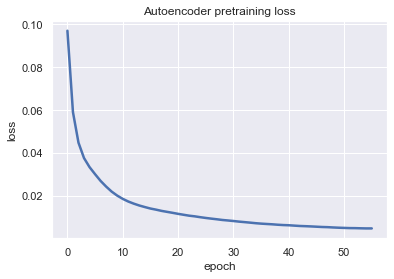

cluster init
232/232 [==============================] - 0s 749us/step
cluster init done
Iter 0: acc = 0.34106, nmi = 0.39830, ari = 0.18773  ; loss= 0
Iter 140: acc = 0.34658, nmi = 0.39835, ari = 0.19008  ; loss= [0.12324 0.19566 0.06454]
Iter 280: acc = 0.34106, nmi = 0.40408, ari = 0.19040  ; loss= [0.11068 0.13106 0.07137]
Iter 420: acc = 0.35291, nmi = 0.41374, ari = 0.19794  ; loss= [0.11073 0.12774 0.07241]
Iter 560: acc = 0.33742, nmi = 0.40515, ari = 0.18932  ; loss= [0.11264 0.12646 0.0747 ]
Iter 700: acc = 0.34779, nmi = 0.40616, ari = 0.19263  ; loss= [0.12203 0.14565 0.07833]
Iter 840: acc = 0.35304, nmi = 0.38879, ari = 0.18217  ; loss= [0.12445 0.14538 0.08083]
Iter 980: acc = 0.35143, nmi = 0.39876, ari = 0.18466  ; loss= [0.12937 0.15289 0.0835 ]
Iter 1120: acc = 0.35574, nmi = 0.40085, ari = 0.18545  ; loss= [0.13669 0.16757 0.08642]
Iter 1260: acc = 0.37150, nmi = 0.41491, ari = 0.20077  ; loss= [0.13897 0.16681 0.08892]
Iter 1400: acc = 0.36422, nmi = 0.41083, ari =

In [ ]:
train_model('reset-metrics-dbscan', cluster="OPTICS", data_rows=1000, entity_count=0, n_clusters=20 )

In [ ]:
train_model('reset-metrics-optics', cluster="OPTICS", data_rows=1000, entity_count=10, n_clusters=15 )


Load Data
Loading ./data/conll_spacy_1000.pkl
Done: (2219, 772)
Splitting
Train data balance:
Most frequent words: 
      entity  freq
0        GPE   464
1     PERSON   445
2   CARDINAL   410
3        ORG   292
4       DATE   267
5    UNKNOWN   146
6    ORDINAL    70
7       TIME    31
8        FAC    17
9      EVENT    16
10   PERCENT    14
11     MONEY    13
12       LOC    12
13  QUANTITY    12
14  LANGUAGE     5
15   PRODUCT     4
16       LAW     1
Resampling


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Drop unused
Split complete
x: (7888, 768), y: (7888,)
{0: 'PERSON', 1: 'UNKNOWN', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'LANGUAGE', 8: 'LAW', 9: 'DATE', 10: 'TIME', 11: 'PERCENT', 12: 'MONEY', 13: 'QUANTITY', 14: 'ORDINAL', 15: 'CARDINAL', 16: 'FAC'}
Data Loaded
Loading AE weights from ./results/reset-metrics-dbscan\jae_weights.h5
Loading model weights from ./results/reset-metrics-dbscan\DEC_model_final.h5
Predicting...
247/247 [==============================] - 0s 1ms/step
Evaluating...
Acc = 0.05882, nmi = 0.00000, ari = 0.00000  ; loss= 0


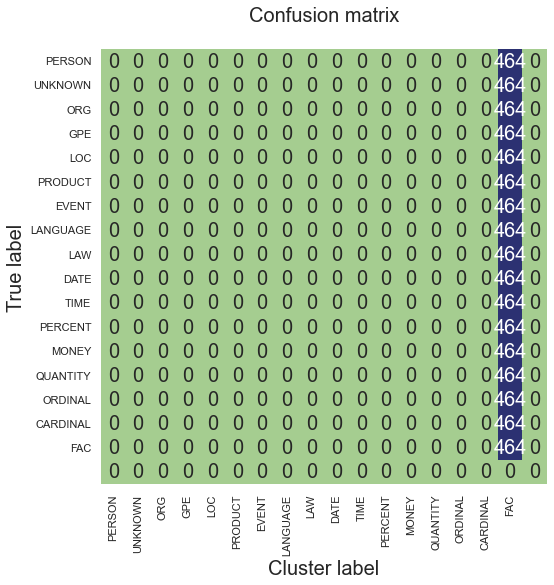

CLUSTERS


100%|██████████| 20/20 [00:00<00:00, 1538.77it/s]

1: "UNK-0", 0 items, (0.00% confidence)
No words for cluster {'freqs': {}, 'frac': 0, 'n': 0, 'name': 'UNK-0', 'idx': 0}
2: "UNK-1", 0 items, (0.00% confidence)
No words for cluster {'freqs': {}, 'frac': 0, 'n': 0, 'name': 'UNK-1', 'idx': 1}
3: "UNK-2", 0 items, (0.00% confidence)
No words for cluster {'freqs': {}, 'frac': 0, 'n': 0, 'name': 'UNK-2', 'idx': 2}
4: "UNK-3", 0 items, (0.00% confidence)
No words for cluster {'freqs': {}, 'frac': 0, 'n': 0, 'name': 'UNK-3', 'idx': 3}
5: "UNK-4", 0 items, (0.00% confidence)
No words for cluster {'freqs': {}, 'frac': 0, 'n': 0, 'name': 'UNK-4', 'idx': 4}
6: "UNK-5", 0 items, (0.00% confidence)
No words for cluster {'freqs': {}, 'frac': 0, 'n': 0, 'name': 'UNK-5', 'idx': 5}
7: "UNK-6", 0 items, (0.00% confidence)
No words for cluster {'freqs': {}, 'frac': 0, 'n': 0, 'name': 'UNK-6', 'idx': 6}
8: "UNK-7", 0 items, (0.00% confidence)
No words for cluster {'freqs': {}, 'frac': 0, 'n': 0, 'name': 'UNK-7', 'idx': 7}
9: "UNK-8", 0 items, (0.00% conf

... wrote ./results/reset-metrics-dbscan\index.html


In [ ]:
evaluate_model('reset-metrics-dbscan',
        entity_count=10,
        data_rows=1000,
        n_clusters=20,
        cluster="DBSCAN",
        )

# benchmark

In [ ]:
# optimal eps https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

from sklearn.neighbors import NearestNeighbors

def optimal_eps(X, n_neighbors=10):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

In [ ]:
def cluster_score(y, y_pred, n_clusters):
    """
    Compute the cluster score.
    Arguments:
        y: true labels.
        y_pred: predicted labels.
        n_clusters: number of clusters.
    Returns:
        cluster score.
    """
    # compute the cluster score
    score = 0
    for i in range(n_clusters):
        score += np.sum(y_pred[y==i]==i)
    return score/len(y)

In [ ]:
def hypertune_density_clustering():
    """
    hypertune the density clustering algorithms.
    """
    eps_vals = [30000.0, 40000.0, 50000.0]
    x, y, mapping, strings = load_data(
                                    1000,
                                    oversample=True,
                                    get_text=True)
    print(f"Optimal epsilon: {optimal_eps(x)}")
    for eps in eps_vals:
        # predict cluster labels
        print(f"Predicting...for epsilon={eps}")
        y_pred, _ = do_clustering('DBSCAN', 25, x, params={'eps':eps})
        print(f"ACC: {cluster_score(y, y_pred, 25)}")
        # confusion matrix
        cm_width = max(8, len(np.unique(y_pred)) * 2)
        cm_width = min(16, cm_width)
        plot_confusion(y, y_pred, mapping, size=cm_width, save_dir=None, details=False)

Loading ./data/conll_spacy_1000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 9: 'DATE', 5: 'GPE', 6: 'LOC', 13: 'QUANTITY', 11: 'PERCENT', 8: 'EVENT', 12: 'MONEY', 3: 'NORP', 14: 'ORDINAL', 16: 'FAC', 10: 'TIME', 15: 'CARDINAL', 7: 'PRODUCT'}
Done: (3348, 772)
Train data balance:
[[   1 2672]
 [   2  153]
 [   3    7]
 [   4  122]
 [   5  249]
 [   6    7]
 [   7    1]
 [   8    5]
 [   9  103]
 [  10    2]
 [  11    3]
 [  12    7]
 [  13    5]
 [  14    3]
 [  15    1]
 [  16    8]]
Balancing data


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (42752, 768), y: (42752,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'DATE', 9: 'TIME', 10: 'PERCENT', 11: 'MONEY', 12: 'QUANTITY', 13: 'ORDINAL', 14: 'CARDINAL', 15: 'FAC'}
Optimal epsilon: None
Predicting...for epsilon=30000.0
ACC: 0.0625


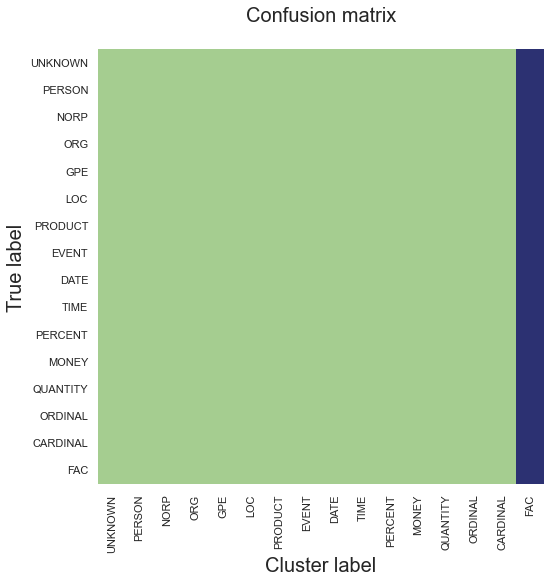

Predicting...for epsilon=40000.0


: 

In [ ]:
hypertune_density_clustering()

In [ ]:
def run_benchmark(cluster:str, eval_size:int, n_clusters:int):
    x, y, mapping, strings = load_data(
                                    eval_size,
                                    oversample=False,
                                    get_text=True)
    save_dir = f'./results/bm/{cluster}'
    if not os.path.exists(save_dir):
        # create save dir
        os.makedirs(save_dir)

    
    # predict cluster labels
    print("Predicting...")
    y_pred, _ = do_clustering(cluster, n_clusters, x)
    # print(f"ACC: {cluster_acc(y, y_pred)}")
    
    # confusion matrix
    cm_width = max(8, len(np.unique(y_pred)) * 2)
    cm_width = min(16, cm_width)
    plot_confusion(y, y_pred, mapping, save_dir, cm_width)

    # show wordclouds for each cluster
    print ("BENCHMARK CLUSTERS")
    clusters = {}
    predicted = DataFrame({'text':strings, 'y_pred':y_pred, 'y_true':y})
    for cluster_no in range(n_clusters):
        y_pred_for_key = predicted[predicted['y_pred']==cluster_no]
        true_label = 'UNKNOWN'
        modal_value = y_pred_for_key['y_true'].mode()
        if len(modal_value)>0:
            if modal_value[0] in mapping:
                true_label = mapping[modal_value[0]]
            # confidence - fraction of this cluster that is actually this cluster
            y_true_this_cluster = len(
                y_pred_for_key[y_pred_for_key['y_true']==modal_value[0]])
            frac = y_true_this_cluster/len(y_pred_for_key)
        else:
            frac = 0

        # wordcloud
        unique, counts = np.unique(y_pred_for_key['text'], return_counts=True)
        freq_list = np.asarray((unique, counts)).T
        freq_list =  sorted(freq_list, key=lambda x: -x[1])[0:50]
        freqs = {w: f for w,f in freq_list}
        entry = {'freqs':freqs, 'frac':frac, 'n':len(y_pred_for_key)}
        if true_label == 'UNKNOWN':
            clusters[f"UNK-{cluster_no}"] = entry
        elif true_label in clusters:
            if clusters[true_label]['frac'] < frac:
                # we found a better cluster for this label
                clusters[true_label] = entry
            else:
                # this cluster is worse than this one, so it's unknown
                clusters[f"UNK-{cluster_no} Was {true_label}"] = entry
        else:
            clusters[true_label] = entry

    cluster_list = [{
        **clusters[c],
        'name': c,
        'idx': idx} for idx, c in enumerate(clusters)]
    cluster_list = sorted(cluster_list, key=lambda x: -x['frac'])

    display_list = []
    # show unknown clusters first
    for i, cluster in enumerate(cluster_list):
        if cluster['name'][0:3] == "UNK":
            save_file = os.path.join(save_dir,
                                     f"wordcloud-{cluster['name']}.png")
            show_wordcloud(i, cluster, save_file, save_only=True)
            display_list.append(cluster)

    # next show known clusters
    for i, cluster in enumerate(cluster_list):
        if cluster['name'][0:3] != "UNK":
            save_file = os.path.join(save_dir,
                                     f"wordcloud-{cluster['name']}.png")
            show_wordcloud(i, cluster, save_file, save_only=True)
            display_list.append(cluster)

    
    print(write_results_page(display_list, save_dir, cluster))

In [ ]:
run_benchmark('Kmeans', 10000, 25)

Loading ./data/conll_spacy_10000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Done: (37748, 772)
Train data balance:
[[    1 31291]
 [    2  1454]
 [    3   102]
 [    4  1344]
 [    5  1842]
 [    6    80]
 [    7    21]
 [    8    32]
 [    9     8]
 [   10     5]
 [   11     5]
 [   12  1100]
 [   13   101]
 [   14    96]
 [   15    73]
 [   16    75]
 [   17     6]
 [   18    44]
 [   19    69]]
x: (37748, 768), y: (37748,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LANGUAGE', 10: 'LAW', 11: 'DATE', 12: 'TIME', 13: 'PERCENT', 14: 'MONEY', 15: 'QUANTITY', 16: 'ORDINAL', 17: 'CARDINAL', 18: 'FAC'}
Predicting...


BENCHMARK CLUSTERS
0: "UNK-6", 515 items, (99.42% confidence)
1: "UNK-3", 2392 items, (96.15% confidence)
2: "UNK-13", 2387 items, (92.71% confidence)
3: "UNK-17", 2505 items, (88.70% confidence)
4: "UNK-23", 3292 items, (88.30% confidence)
5: "UNK-22", 2734 items, (87.49% confidence)
6: "UNK-12", 3108 items, (87.03% confidence)
7: "UNK-1", 1530 items, (86.93% confidence)
8: "UNK-21", 445 items, (86.74% confidence)
9: "UNK-7", 1221 items, (85.18% confidence)
10: "UNK-24", 751 items, (82.29% confidence)
11: "UNK-4", 1007 items, (80.73% confidence)
12: "UNK-11", 2178 items, (80.72% confidence)
13: "UNK-8", 1189 items, (80.57% confidence)
14: "UNK-0", 3199 items, (78.46% confidence)
15: "UNK-2", 348 items, (78.16% confidence)
16: "UNK-15", 1132 items, (76.41% confidence)
17: "UNK-16", 886 items, (75.73% confidence)
18: "UNK-10", 925 items, (75.46% confidence)
19: "UNK-20", 968 items, (74.90% confidence)
20: "UNK-14", 1259 items, (74.11% confidence)
21: "UNK-5", 663 items, (72.55% confiden

In [ ]:
run_benchmark('GMM', 10000, 25)

Loading ./data/conll_spacy_10000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Done: (37748, 772)
Train data balance:
[[    1 31291]
 [    2  1454]
 [    3   102]
 [    4  1344]
 [    5  1842]
 [    6    80]
 [    7    21]
 [    8    32]
 [    9     8]
 [   10     5]
 [   11     5]
 [   12  1100]
 [   13   101]
 [   14    96]
 [   15    73]
 [   16    75]
 [   17     6]
 [   18    44]
 [   19    69]]
x: (37748, 768), y: (37748,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LANGUAGE', 10: 'LAW', 11: 'DATE', 12: 'TIME', 13: 'PERCENT', 14: 'MONEY', 15: 'QUANTITY', 16: 'ORDINAL', 17: 'CARDINAL', 18: 'FAC'}
Predicting...


BENCHMARK CLUSTERS
0: "UNK-11", 724 items, (96.41% confidence)
1: "UNK-22", 2258 items, (92.96% confidence)
2: "UNK-4", 3181 items, (92.08% confidence)
3: "UNK-2", 2678 items, (89.06% confidence)
4: "UNK-5", 1297 items, (88.43% confidence)
5: "UNK-8", 442 items, (86.88% confidence)
6: "UNK-24", 3011 items, (86.85% confidence)
7: "UNK-23", 1138 items, (85.06% confidence)
8: "UNK-7", 1999 items, (84.94% confidence)
9: "UNK-6", 3378 items, (84.49% confidence)
10: "UNK-20", 1599 items, (81.68% confidence)
11: "UNK-0", 748 items, (81.55% confidence)
12: "UNK-16", 1434 items, (81.31% confidence)
13: "UNK-13", 1010 items, (80.79% confidence)
14: "UNK-15", 2243 items, (80.07% confidence)
15: "UNK-1", 355 items, (78.59% confidence)
16: "UNK-14", 2979 items, (78.05% confidence)
17: "UNK-17", 984 items, (76.93% confidence)
18: "UNK-9", 738 items, (76.69% confidence)
19: "UNK-18", 1117 items, (74.75% confidence)
20: "UNK-21", 914 items, (73.85% confidence)
21: "UNK-19", 1253 items, (73.02% confide

Loading ./data/conll_spacy_10000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Done: (37748, 772)
Train data balance:
[[    1 31291]
 [    2  1454]
 [    3   102]
 [    4  1344]
 [    5  1842]
 [    6    80]
 [    7    21]
 [    8    32]
 [    9     8]
 [   10     5]
 [   11     5]
 [   12  1100]
 [   13   101]
 [   14    96]
 [   15    73]
 [   16    75]
 [   17     6]
 [   18    44]
 [   19    69]]
x: (37748, 768), y: (37748,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LANGUAGE', 10: 'LAW', 11: 'DATE', 12: 'TIME', 13: 'PERCENT', 14: 'MONEY', 15: 'QUANTITY', 16: 'ORDINAL', 17: 'CARDINAL', 18: 'FAC'}
Predicting...


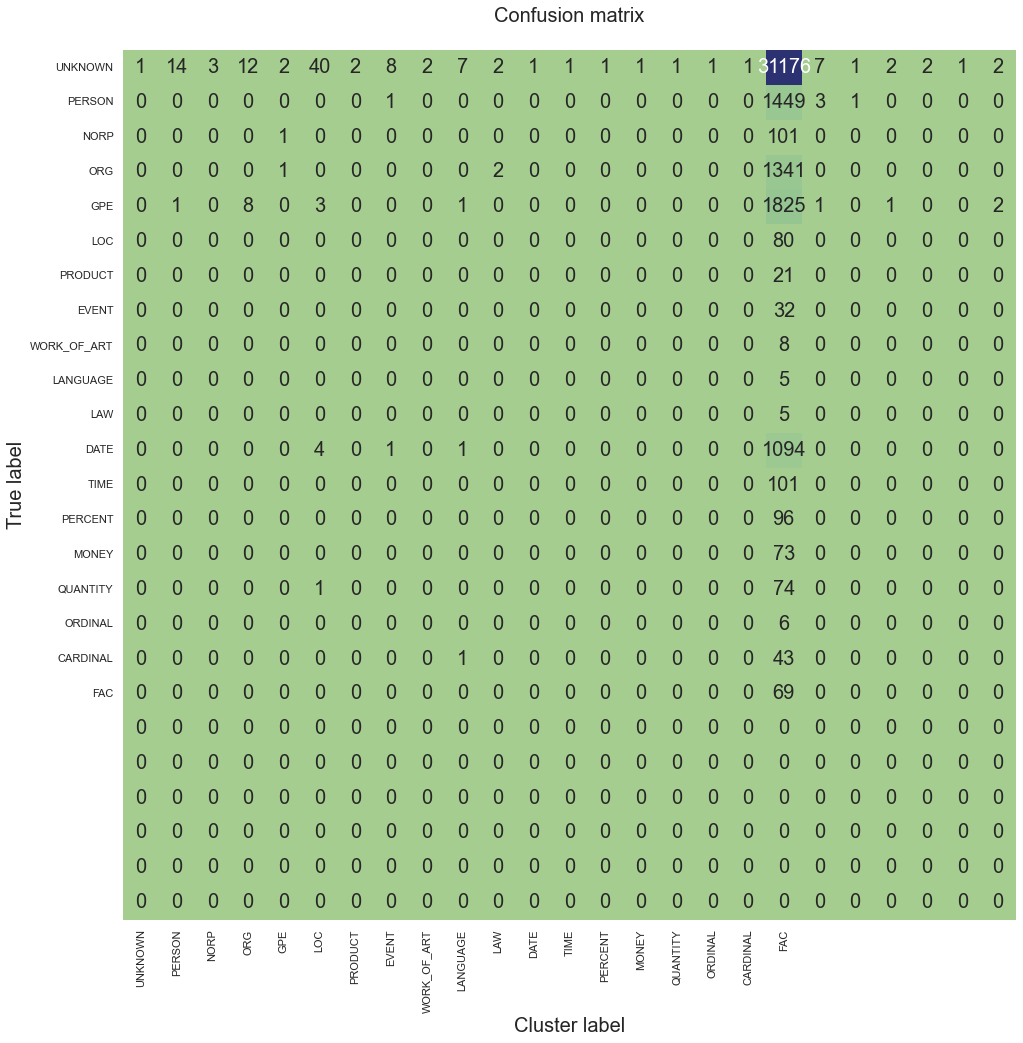

BENCHMARK CLUSTERS
0: "UNK-3", 3 items, (100.00% confidence)
1: "UNK-7", 2 items, (100.00% confidence)
2: "UNK-9", 2 items, (100.00% confidence)
3: "UNK-12", 1 items, (100.00% confidence)
4: "UNK-13", 1 items, (100.00% confidence)
5: "UNK-14", 1 items, (100.00% confidence)
6: "UNK-15", 1 items, (100.00% confidence)
7: "UNK-16", 1 items, (100.00% confidence)
8: "UNK-17", 1 items, (100.00% confidence)
9: "UNK-18", 1 items, (100.00% confidence)
10: "UNK-21", 2 items, (100.00% confidence)
11: "UNK-22", 1 items, (100.00% confidence)
12: "UNK-24", 1 items, (100.00% confidence)
13: "UNK-2", 15 items, (93.33% confidence)
14: "UNK-6", 48 items, (83.33% confidence)
15: "UNK-0", 37599 items, (82.92% confidence)
16: "UNK-8", 10 items, (80.00% confidence)
17: "UNK-10", 10 items, (70.00% confidence)
18: "UNK-20", 3 items, (66.67% confidence)
19: "UNK-1", 11 items, (63.64% confidence)
20: "UNK-4", 20 items, (60.00% confidence)
21: "UNK-5", 4 items, (50.00% confidence)
22: "UNK-11", 4 items, (50.00% c

In [ ]:
run_benchmark('agg', 10000, 25)